# Demo

The purpose of this demo is to show that using our implementation of SGHMC we get good uncertainty estimates on out-of-distribution examples, which is the key benefit of Bayesian inference.

In [1]:
import sys
sys.path.append("..")

import time
import numpy as np
import matplotlib.pyplot as plt

import os
from PIL import Image

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F

import seaborn as sns # conda install seaborn
import pandas as pd # ^^ this will automatically install pandas

import pyro
from pyro.infer.mcmc import MCMC
import pyro.distributions as dist

from kernel.sghmc import SGHMC

pyro.set_rng_seed(101)

plt.rcParams['figure.dpi'] = 300

In [2]:
# Simple dataset wrapper class

class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return(len(self.data))
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

### Hyperparams

In [3]:
BATCH_SIZE = 500
NUM_EPOCHS = 800
WARMUP_EPOCHS = 50
HIDDEN_SIZE = 100

### Download MNIST and setup datasets / dataloaders

In [4]:
train_dataset = datasets.MNIST('./data', train=True, download=True)

test_dataset = datasets.MNIST('./data', train=False, download=True)

nvalid = 10000

perm = torch.arange(len(train_dataset))
train_idx = perm[nvalid:]
val_idx = perm[:nvalid]

# scale the datasets
X_train = train_dataset.data[train_idx] / 255.0
Y_train = train_dataset.targets[train_idx]

X_val = train_dataset.data[val_idx] / 255.0 
Y_val = train_dataset.targets[val_idx]

X_test = test_dataset.data / 255.0
Y_test = test_dataset.targets

# redefine the datasets
train_dataset = Dataset(X_train, Y_train)
val_dataset = Dataset(X_val, Y_val)
test_dataset = Dataset(X_test, Y_test)

# setup the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Load out-of-distribution examples

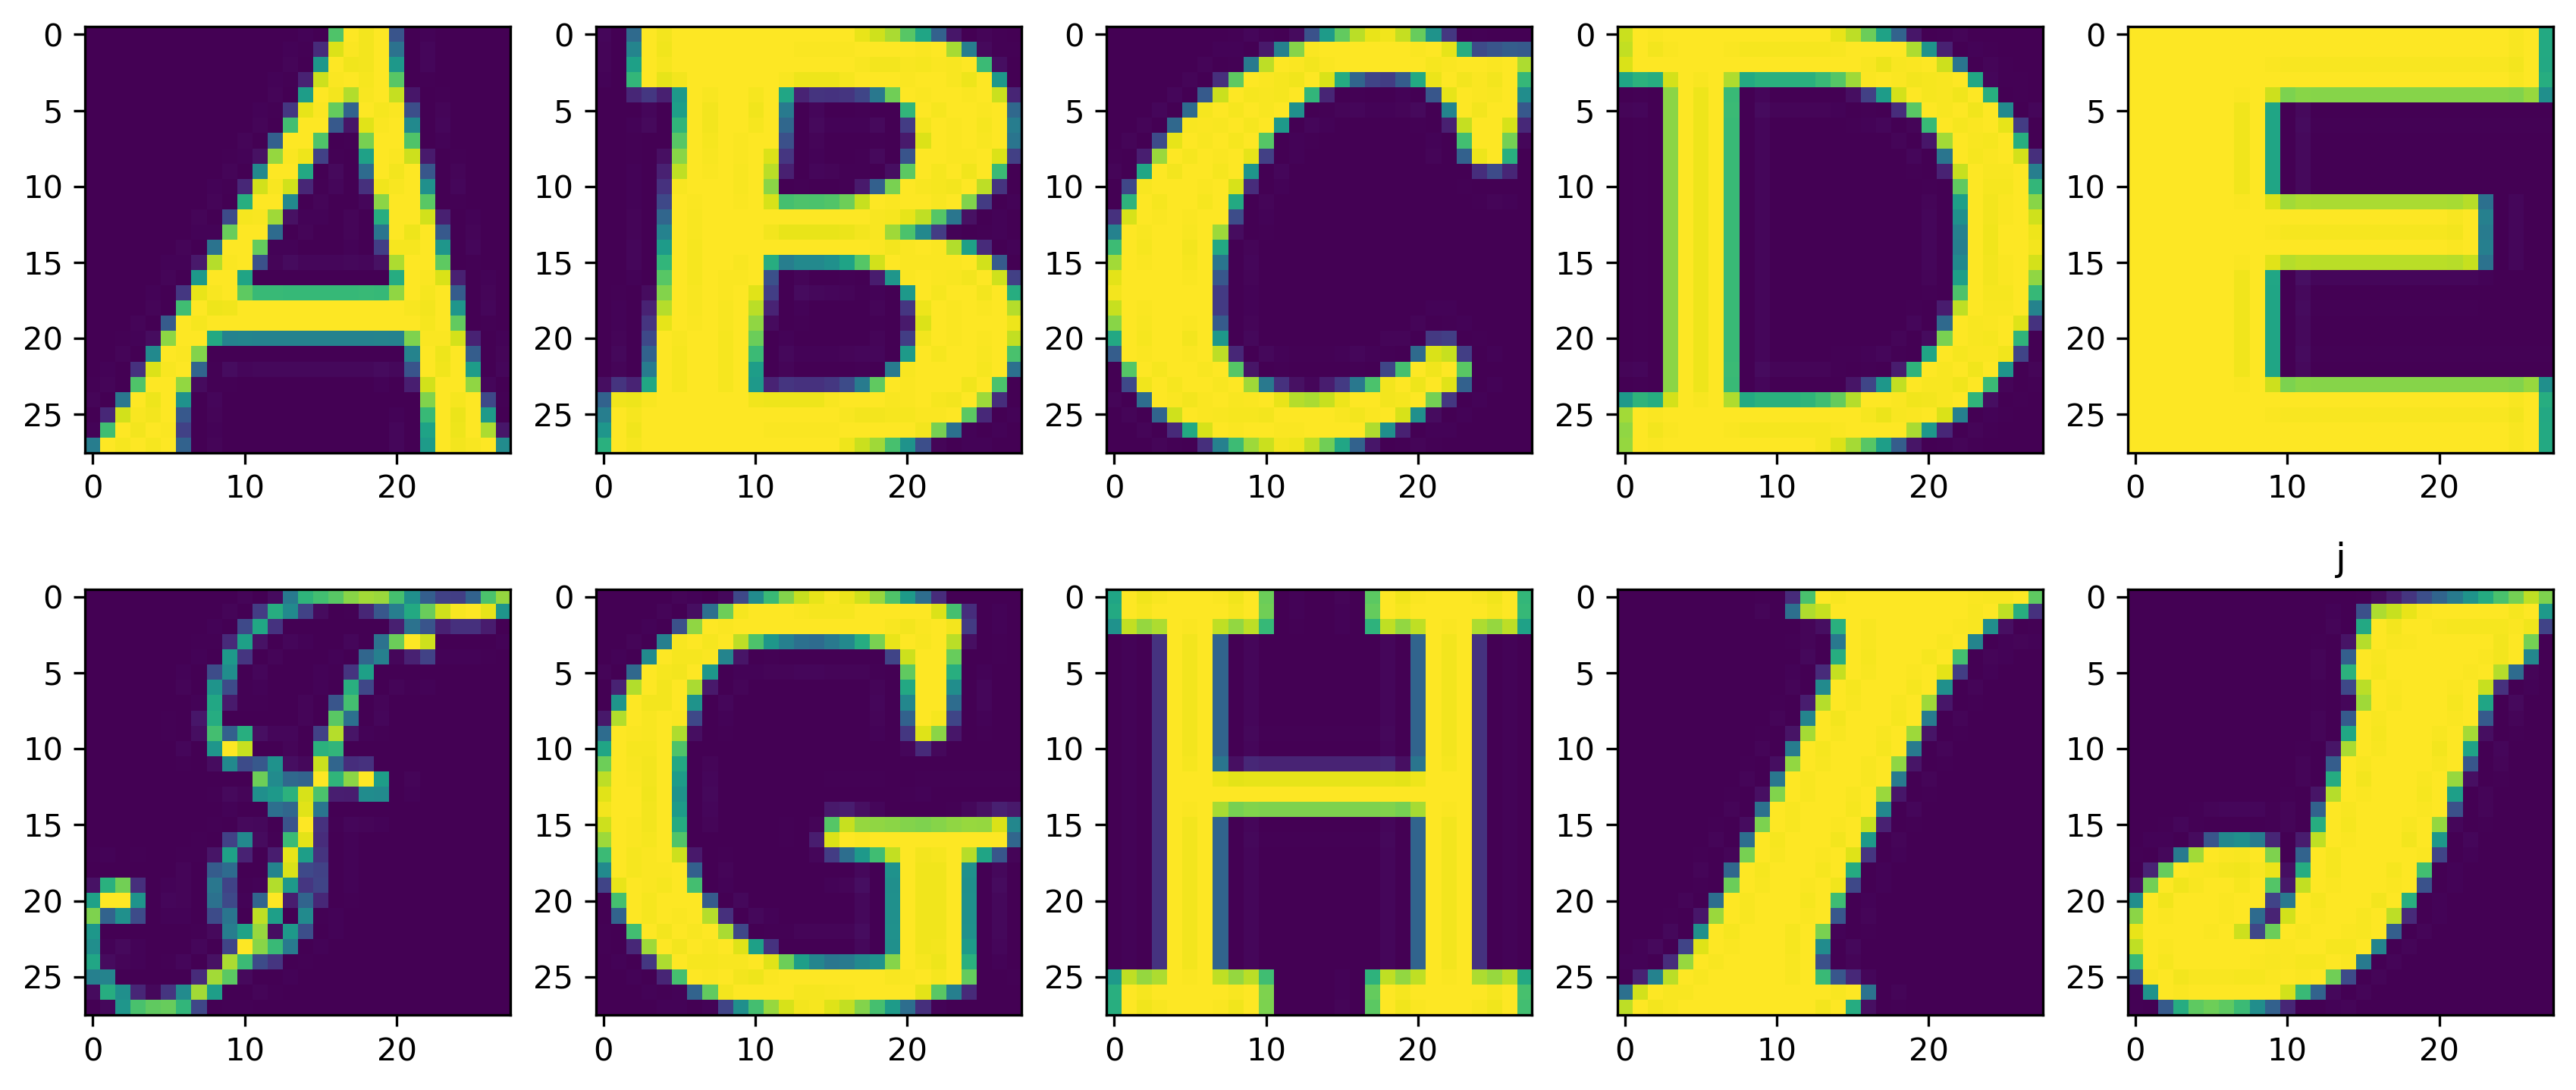

In [5]:
# load the test letter dataset
letters = ["a","b","c","d","e","f","g","h","i","j"]
x_letters = np.array([np.array(Image.open("data/not-mnist/%s.png"%(l)))
                         for l in letters]).astype(np.float32)# loads letters data
x_letters /= np.max(x_letters, axis=(1,2), keepdims=True)# normalise
x_letters = torch.from_numpy(x_letters)

plt.figure(figsize=(14,6))

for iplot,i in enumerate([0,1,2,3,4]):
    plt.subplot(2,5,iplot+1)
    plt.imshow(x_letters[i].numpy())
    
for iplot,i in enumerate([5,6,7,8,9]):
    plt.subplot(2,5,iplot+6)
    plt.imshow(x_letters[i].numpy()) 
    
plt.title(letters[i])
plt.show()

### Define the Bayesian neural network  model

In [6]:
PyroLinear = pyro.nn.PyroModule[torch.nn.Linear]
    
class BNN(pyro.nn.PyroModule):
    
    def __init__(self, input_size, hidden_size, output_size, prec=1.):
        super().__init__()
        # prec is a kwarg that should only used by SGD to set the regularization strength 
        # recall that a Guassian prior over the weights is equivalent to L2 norm regularization in the non-Bayes setting
        
        # TODO add gamma priors to precision terms
        self.fc1 = PyroLinear(input_size, hidden_size)
        self.fc1.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size, input_size]).to_event(2))
        self.fc1.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([hidden_size]).to_event(1))
        
        self.fc2 = PyroLinear(hidden_size, output_size)
        self.fc2.weight = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size, hidden_size]).to_event(2))
        self.fc2.bias   = pyro.nn.PyroSample(dist.Normal(0., prec).expand([output_size]).to_event(1))
        
        self.relu = torch.nn.ReLU()
        self.log_softmax = torch.nn.LogSoftmax(dim=1)

    def forward(self, x, y=None):
        x = x.view(-1, 28*28)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.log_softmax(x)# output (log) softmax probabilities of each class
        
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Categorical(logits=x), obs=y)

### Run SGHMC 

We run SGHMC to sample approximately from the posterior distribution.

In [7]:
LR = 2e-6
MOMENTUM_DECAY = 0.01
RESAMPLE_EVERY_N = 0
NUM_STEPS = 1

pyro.clear_param_store()

bnn = BNN(28*28, HIDDEN_SIZE, 10)

sghmc = SGHMC(bnn,
              subsample_positions=[0, 1],
              batch_size=BATCH_SIZE,
              learning_rate=LR,
              momentum_decay=MOMENTUM_DECAY,
              num_steps=NUM_STEPS,
              resample_every_n=RESAMPLE_EVERY_N)

sghmc_mcmc = MCMC(sghmc, num_samples=len(train_dataset)//BATCH_SIZE, warmup_steps=0)

sghmc_test_errs = []

# full posterior predictive 
full_predictive = torch.FloatTensor(10000, 10)
full_predictive.zero_()

# full letter posterior predictive
full_letter_predictive = torch.FloatTensor(10, 10)
full_letter_predictive.zero_()

for epoch in range(1, 1+NUM_EPOCHS + WARMUP_EPOCHS):
    sghmc_mcmc.run(X_train, Y_train)
    
    if epoch >= WARMUP_EPOCHS:
        
        sghmc_samples = sghmc_mcmc.get_samples()
        predictive = pyro.infer.Predictive(bnn, posterior_samples=sghmc_samples)
        start = time.time()
        
        with torch.no_grad():
            epoch_predictive = None
            for x, y in val_loader:
                if epoch_predictive is None:
                    epoch_predictive = predictive(x)['obs'].to(torch.int64)
                else:
                    epoch_predictive = torch.cat((epoch_predictive, predictive(x)['obs'].to(torch.int64)), dim=1)
        
            for sample in epoch_predictive:
                predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_predictive = full_predictive + predictive_one_hot
                
            full_y_hat = torch.argmax(full_predictive, dim=1)
            total = Y_val.shape[0]
            correct = int((full_y_hat == Y_val).sum())
            
            letter_predictive = None
            for i in range(x_letters.shape[0]):
                letter = x_letters[i, :, :]
                if letter_predictive is None:
                    letter_predictive = predictive(letter)['obs'].to(torch.int64)
                else:
                    letter_predictive = torch.cat((letter_predictive, predictive(letter)['obs'].to(torch.int64)), dim=1)
                    
            for sample in letter_predictive:
                letter_predictive_one_hot = F.one_hot(sample, num_classes=10)
                full_letter_predictive = full_letter_predictive + letter_predictive_one_hot
            
        end = time.time()
        
        sghmc_test_errs.append(1.0 - correct/total)

        print("Epoch [{}/{}] test accuracy: {:.4f} time: {:.2f}".format(epoch-WARMUP_EPOCHS, NUM_EPOCHS, correct/total, end - start))

Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.78it/s, lr=2.00e-06]


Epoch [0/800] test accuracy: 0.9161 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.92it/s, lr=2.00e-06]


Epoch [1/800] test accuracy: 0.9205 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.72it/s, lr=2.00e-06]


Epoch [2/800] test accuracy: 0.9214 time: 6.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.21it/s, lr=2.00e-06]


Epoch [3/800] test accuracy: 0.9236 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.74it/s, lr=2.00e-06]


Epoch [4/800] test accuracy: 0.9245 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.44it/s, lr=2.00e-06]


Epoch [5/800] test accuracy: 0.9250 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.16it/s, lr=2.00e-06]


Epoch [6/800] test accuracy: 0.9259 time: 6.38


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.61it/s, lr=2.00e-06]


Epoch [7/800] test accuracy: 0.9259 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.26it/s, lr=2.00e-06]


Epoch [8/800] test accuracy: 0.9263 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.24it/s, lr=2.00e-06]


Epoch [9/800] test accuracy: 0.9269 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.27it/s, lr=2.00e-06]


Epoch [10/800] test accuracy: 0.9277 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.02it/s, lr=2.00e-06]


Epoch [11/800] test accuracy: 0.9279 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.31it/s, lr=2.00e-06]


Epoch [12/800] test accuracy: 0.9286 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.33it/s, lr=2.00e-06]


Epoch [13/800] test accuracy: 0.9293 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.88it/s, lr=2.00e-06]


Epoch [14/800] test accuracy: 0.9295 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.59it/s, lr=2.00e-06]


Epoch [15/800] test accuracy: 0.9298 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.15it/s, lr=2.00e-06]


Epoch [16/800] test accuracy: 0.9304 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.38it/s, lr=2.00e-06]


Epoch [17/800] test accuracy: 0.9311 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.71it/s, lr=2.00e-06]


Epoch [18/800] test accuracy: 0.9312 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.47it/s, lr=2.00e-06]


Epoch [19/800] test accuracy: 0.9322 time: 6.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.83it/s, lr=2.00e-06]


Epoch [20/800] test accuracy: 0.9323 time: 6.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.91it/s, lr=2.00e-06]


Epoch [21/800] test accuracy: 0.9327 time: 6.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.64it/s, lr=2.00e-06]


Epoch [22/800] test accuracy: 0.9330 time: 6.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.92it/s, lr=2.00e-06]


Epoch [23/800] test accuracy: 0.9336 time: 6.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.06it/s, lr=2.00e-06]


Epoch [24/800] test accuracy: 0.9341 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.50it/s, lr=2.00e-06]


Epoch [25/800] test accuracy: 0.9349 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.09it/s, lr=2.00e-06]


Epoch [26/800] test accuracy: 0.9349 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.06it/s, lr=2.00e-06]


Epoch [27/800] test accuracy: 0.9355 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.23it/s, lr=2.00e-06]


Epoch [28/800] test accuracy: 0.9357 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.26it/s, lr=2.00e-06]


Epoch [29/800] test accuracy: 0.9358 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.62it/s, lr=2.00e-06]


Epoch [30/800] test accuracy: 0.9361 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.47it/s, lr=2.00e-06]


Epoch [31/800] test accuracy: 0.9359 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.66it/s, lr=2.00e-06]


Epoch [32/800] test accuracy: 0.9371 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.49it/s, lr=2.00e-06]


Epoch [33/800] test accuracy: 0.9375 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.20it/s, lr=2.00e-06]


Epoch [34/800] test accuracy: 0.9372 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.23it/s, lr=2.00e-06]


Epoch [35/800] test accuracy: 0.9375 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.99it/s, lr=2.00e-06]


Epoch [36/800] test accuracy: 0.9382 time: 6.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.64it/s, lr=2.00e-06]


Epoch [37/800] test accuracy: 0.9380 time: 6.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.93it/s, lr=2.00e-06]


Epoch [38/800] test accuracy: 0.9379 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.09it/s, lr=2.00e-06]


Epoch [39/800] test accuracy: 0.9384 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.75it/s, lr=2.00e-06]


Epoch [40/800] test accuracy: 0.9387 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.36it/s, lr=2.00e-06]


Epoch [41/800] test accuracy: 0.9389 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.97it/s, lr=2.00e-06]


Epoch [42/800] test accuracy: 0.9390 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.48it/s, lr=2.00e-06]


Epoch [43/800] test accuracy: 0.9397 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.19it/s, lr=2.00e-06]


Epoch [44/800] test accuracy: 0.9398 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.10it/s, lr=2.00e-06]


Epoch [45/800] test accuracy: 0.9402 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.73it/s, lr=2.00e-06]


Epoch [46/800] test accuracy: 0.9402 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.75it/s, lr=2.00e-06]


Epoch [47/800] test accuracy: 0.9405 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.76it/s, lr=2.00e-06]


Epoch [48/800] test accuracy: 0.9408 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.08it/s, lr=2.00e-06]


Epoch [49/800] test accuracy: 0.9412 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.39it/s, lr=2.00e-06]


Epoch [50/800] test accuracy: 0.9416 time: 6.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.90it/s, lr=2.00e-06]


Epoch [51/800] test accuracy: 0.9419 time: 6.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.42it/s, lr=2.00e-06]


Epoch [52/800] test accuracy: 0.9420 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.71it/s, lr=2.00e-06]


Epoch [53/800] test accuracy: 0.9420 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.56it/s, lr=2.00e-06]


Epoch [54/800] test accuracy: 0.9418 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.53it/s, lr=2.00e-06]


Epoch [55/800] test accuracy: 0.9424 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.06it/s, lr=2.00e-06]


Epoch [56/800] test accuracy: 0.9425 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.83it/s, lr=2.00e-06]


Epoch [57/800] test accuracy: 0.9426 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.66it/s, lr=2.00e-06]


Epoch [58/800] test accuracy: 0.9430 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.10it/s, lr=2.00e-06]


Epoch [59/800] test accuracy: 0.9437 time: 5.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.89it/s, lr=2.00e-06]


Epoch [60/800] test accuracy: 0.9443 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.58it/s, lr=2.00e-06]


Epoch [61/800] test accuracy: 0.9444 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.02it/s, lr=2.00e-06]


Epoch [62/800] test accuracy: 0.9446 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.19it/s, lr=2.00e-06]


Epoch [63/800] test accuracy: 0.9454 time: 6.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.48it/s, lr=2.00e-06]


Epoch [64/800] test accuracy: 0.9459 time: 6.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.98it/s, lr=2.00e-06]


Epoch [65/800] test accuracy: 0.9458 time: 6.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.51it/s, lr=2.00e-06]


Epoch [66/800] test accuracy: 0.9457 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.28it/s, lr=2.00e-06]


Epoch [67/800] test accuracy: 0.9459 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.67it/s, lr=2.00e-06]


Epoch [68/800] test accuracy: 0.9458 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.60it/s, lr=2.00e-06]


Epoch [69/800] test accuracy: 0.9464 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.16it/s, lr=2.00e-06]


Epoch [70/800] test accuracy: 0.9467 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.61it/s, lr=2.00e-06]


Epoch [71/800] test accuracy: 0.9465 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.16it/s, lr=2.00e-06]


Epoch [72/800] test accuracy: 0.9468 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.06it/s, lr=2.00e-06]


Epoch [73/800] test accuracy: 0.9471 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.14it/s, lr=2.00e-06]


Epoch [74/800] test accuracy: 0.9473 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.88it/s, lr=2.00e-06]


Epoch [75/800] test accuracy: 0.9475 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.30it/s, lr=2.00e-06]


Epoch [76/800] test accuracy: 0.9475 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.21it/s, lr=2.00e-06]


Epoch [77/800] test accuracy: 0.9479 time: 6.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.10it/s, lr=2.00e-06]


Epoch [78/800] test accuracy: 0.9484 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.01it/s, lr=2.00e-06]


Epoch [79/800] test accuracy: 0.9489 time: 6.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.83it/s, lr=2.00e-06]


Epoch [80/800] test accuracy: 0.9491 time: 6.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.13it/s, lr=2.00e-06]


Epoch [81/800] test accuracy: 0.9491 time: 6.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.36it/s, lr=2.00e-06]


Epoch [82/800] test accuracy: 0.9489 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.70it/s, lr=2.00e-06]


Epoch [83/800] test accuracy: 0.9491 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.07it/s, lr=2.00e-06]


Epoch [84/800] test accuracy: 0.9494 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.21it/s, lr=2.00e-06]


Epoch [85/800] test accuracy: 0.9497 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.30it/s, lr=2.00e-06]


Epoch [86/800] test accuracy: 0.9497 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.39it/s, lr=2.00e-06]


Epoch [87/800] test accuracy: 0.9499 time: 5.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.42it/s, lr=2.00e-06]


Epoch [88/800] test accuracy: 0.9499 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.77it/s, lr=2.00e-06]


Epoch [89/800] test accuracy: 0.9501 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.18it/s, lr=2.00e-06]


Epoch [90/800] test accuracy: 0.9500 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.19it/s, lr=2.00e-06]


Epoch [91/800] test accuracy: 0.9502 time: 5.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.10it/s, lr=2.00e-06]


Epoch [92/800] test accuracy: 0.9506 time: 6.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.07it/s, lr=2.00e-06]


Epoch [93/800] test accuracy: 0.9508 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.25it/s, lr=2.00e-06]


Epoch [94/800] test accuracy: 0.9508 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.37it/s, lr=2.00e-06]


Epoch [95/800] test accuracy: 0.9508 time: 6.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.88it/s, lr=2.00e-06]


Epoch [96/800] test accuracy: 0.9508 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.44it/s, lr=2.00e-06]


Epoch [97/800] test accuracy: 0.9510 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [98/800] test accuracy: 0.9510 time: 5.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.38it/s, lr=2.00e-06]


Epoch [99/800] test accuracy: 0.9513 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.60it/s, lr=2.00e-06]


Epoch [100/800] test accuracy: 0.9515 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.39it/s, lr=2.00e-06]


Epoch [101/800] test accuracy: 0.9515 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.03it/s, lr=2.00e-06]


Epoch [102/800] test accuracy: 0.9517 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.80it/s, lr=2.00e-06]


Epoch [103/800] test accuracy: 0.9517 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.77it/s, lr=2.00e-06]


Epoch [104/800] test accuracy: 0.9519 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.98it/s, lr=2.00e-06]


Epoch [105/800] test accuracy: 0.9521 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.56it/s, lr=2.00e-06]


Epoch [106/800] test accuracy: 0.9523 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.56it/s, lr=2.00e-06]


Epoch [107/800] test accuracy: 0.9527 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.91it/s, lr=2.00e-06]


Epoch [108/800] test accuracy: 0.9527 time: 6.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.76it/s, lr=2.00e-06]


Epoch [109/800] test accuracy: 0.9527 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.99it/s, lr=2.00e-06]


Epoch [110/800] test accuracy: 0.9529 time: 6.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.94it/s, lr=2.00e-06]


Epoch [111/800] test accuracy: 0.9531 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.00it/s, lr=2.00e-06]


Epoch [112/800] test accuracy: 0.9531 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.66it/s, lr=2.00e-06]


Epoch [113/800] test accuracy: 0.9531 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.47it/s, lr=2.00e-06]


Epoch [114/800] test accuracy: 0.9535 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.40it/s, lr=2.00e-06]


Epoch [115/800] test accuracy: 0.9535 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.36it/s, lr=2.00e-06]


Epoch [116/800] test accuracy: 0.9535 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.68it/s, lr=2.00e-06]


Epoch [117/800] test accuracy: 0.9535 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.54it/s, lr=2.00e-06]


Epoch [118/800] test accuracy: 0.9535 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.95it/s, lr=2.00e-06]


Epoch [119/800] test accuracy: 0.9535 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.75it/s, lr=2.00e-06]


Epoch [120/800] test accuracy: 0.9537 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.57it/s, lr=2.00e-06]


Epoch [121/800] test accuracy: 0.9538 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.89it/s, lr=2.00e-06]


Epoch [122/800] test accuracy: 0.9537 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.64it/s, lr=2.00e-06]


Epoch [123/800] test accuracy: 0.9537 time: 6.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.97it/s, lr=2.00e-06]


Epoch [124/800] test accuracy: 0.9538 time: 6.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.27it/s, lr=2.00e-06]


Epoch [125/800] test accuracy: 0.9539 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.52it/s, lr=2.00e-06]


Epoch [126/800] test accuracy: 0.9537 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.43it/s, lr=2.00e-06]


Epoch [127/800] test accuracy: 0.9537 time: 5.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.30it/s, lr=2.00e-06]


Epoch [128/800] test accuracy: 0.9536 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.53it/s, lr=2.00e-06]


Epoch [129/800] test accuracy: 0.9536 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.58it/s, lr=2.00e-06]


Epoch [130/800] test accuracy: 0.9537 time: 5.81


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.51it/s, lr=2.00e-06]


Epoch [131/800] test accuracy: 0.9536 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [132/800] test accuracy: 0.9537 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.19it/s, lr=2.00e-06]


Epoch [133/800] test accuracy: 0.9536 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.49it/s, lr=2.00e-06]


Epoch [134/800] test accuracy: 0.9536 time: 6.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.85it/s, lr=2.00e-06]


Epoch [135/800] test accuracy: 0.9538 time: 5.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.97it/s, lr=2.00e-06]


Epoch [136/800] test accuracy: 0.9538 time: 6.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.17it/s, lr=2.00e-06]


Epoch [137/800] test accuracy: 0.9538 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.17it/s, lr=2.00e-06]


Epoch [138/800] test accuracy: 0.9537 time: 6.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.65it/s, lr=2.00e-06]


Epoch [139/800] test accuracy: 0.9537 time: 6.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.75it/s, lr=2.00e-06]


Epoch [140/800] test accuracy: 0.9539 time: 6.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.35it/s, lr=2.00e-06]


Epoch [141/800] test accuracy: 0.9538 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.41it/s, lr=2.00e-06]


Epoch [142/800] test accuracy: 0.9539 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.41it/s, lr=2.00e-06]


Epoch [143/800] test accuracy: 0.9538 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.99it/s, lr=2.00e-06]


Epoch [144/800] test accuracy: 0.9538 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.12it/s, lr=2.00e-06]


Epoch [145/800] test accuracy: 0.9541 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.30it/s, lr=2.00e-06]


Epoch [146/800] test accuracy: 0.9541 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.51it/s, lr=2.00e-06]


Epoch [147/800] test accuracy: 0.9542 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.53it/s, lr=2.00e-06]


Epoch [148/800] test accuracy: 0.9542 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.83it/s, lr=2.00e-06]


Epoch [149/800] test accuracy: 0.9543 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.78it/s, lr=2.00e-06]


Epoch [150/800] test accuracy: 0.9544 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.57it/s, lr=2.00e-06]


Epoch [151/800] test accuracy: 0.9544 time: 6.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.36it/s, lr=2.00e-06]


Epoch [152/800] test accuracy: 0.9545 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.94it/s, lr=2.00e-06]


Epoch [153/800] test accuracy: 0.9547 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.67it/s, lr=2.00e-06]


Epoch [154/800] test accuracy: 0.9546 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.73it/s, lr=2.00e-06]


Epoch [155/800] test accuracy: 0.9545 time: 6.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.35it/s, lr=2.00e-06]


Epoch [156/800] test accuracy: 0.9545 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.62it/s, lr=2.00e-06]


Epoch [157/800] test accuracy: 0.9547 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.42it/s, lr=2.00e-06]


Epoch [158/800] test accuracy: 0.9545 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.04it/s, lr=2.00e-06]


Epoch [159/800] test accuracy: 0.9543 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.75it/s, lr=2.00e-06]


Epoch [160/800] test accuracy: 0.9545 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.51it/s, lr=2.00e-06]


Epoch [161/800] test accuracy: 0.9546 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.04it/s, lr=2.00e-06]


Epoch [162/800] test accuracy: 0.9545 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.99it/s, lr=2.00e-06]


Epoch [163/800] test accuracy: 0.9546 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.08it/s, lr=2.00e-06]


Epoch [164/800] test accuracy: 0.9546 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.44it/s, lr=2.00e-06]


Epoch [165/800] test accuracy: 0.9545 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.03it/s, lr=2.00e-06]


Epoch [166/800] test accuracy: 0.9544 time: 6.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.37it/s, lr=2.00e-06]


Epoch [167/800] test accuracy: 0.9545 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.69it/s, lr=2.00e-06]


Epoch [168/800] test accuracy: 0.9545 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.54it/s, lr=2.00e-06]


Epoch [169/800] test accuracy: 0.9545 time: 6.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.68it/s, lr=2.00e-06]


Epoch [170/800] test accuracy: 0.9545 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.55it/s, lr=2.00e-06]


Epoch [171/800] test accuracy: 0.9546 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.50it/s, lr=2.00e-06]


Epoch [172/800] test accuracy: 0.9548 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.89it/s, lr=2.00e-06]


Epoch [173/800] test accuracy: 0.9548 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.74it/s, lr=2.00e-06]


Epoch [174/800] test accuracy: 0.9547 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.56it/s, lr=2.00e-06]


Epoch [175/800] test accuracy: 0.9548 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.08it/s, lr=2.00e-06]


Epoch [176/800] test accuracy: 0.9547 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.75it/s, lr=2.00e-06]


Epoch [177/800] test accuracy: 0.9547 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.24it/s, lr=2.00e-06]


Epoch [178/800] test accuracy: 0.9547 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.99it/s, lr=2.00e-06]


Epoch [179/800] test accuracy: 0.9547 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.23it/s, lr=2.00e-06]


Epoch [180/800] test accuracy: 0.9549 time: 8.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:03, 32.38it/s, lr=2.00e-06]


Epoch [181/800] test accuracy: 0.9548 time: 7.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.08it/s, lr=2.00e-06]


Epoch [182/800] test accuracy: 0.9548 time: 6.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.29it/s, lr=2.00e-06]


Epoch [183/800] test accuracy: 0.9548 time: 6.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.54it/s, lr=2.00e-06]


Epoch [184/800] test accuracy: 0.9548 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.88it/s, lr=2.00e-06]


Epoch [185/800] test accuracy: 0.9548 time: 5.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.58it/s, lr=2.00e-06]


Epoch [186/800] test accuracy: 0.9548 time: 5.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.01it/s, lr=2.00e-06]


Epoch [187/800] test accuracy: 0.9550 time: 5.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.19it/s, lr=2.00e-06]


Epoch [188/800] test accuracy: 0.9550 time: 5.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.02it/s, lr=2.00e-06]


Epoch [189/800] test accuracy: 0.9551 time: 5.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.32it/s, lr=2.00e-06]


Epoch [190/800] test accuracy: 0.9552 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.90it/s, lr=2.00e-06]


Epoch [191/800] test accuracy: 0.9552 time: 5.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.67it/s, lr=2.00e-06]


Epoch [192/800] test accuracy: 0.9552 time: 5.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.28it/s, lr=2.00e-06]


Epoch [193/800] test accuracy: 0.9553 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.90it/s, lr=2.00e-06]


Epoch [194/800] test accuracy: 0.9553 time: 5.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.82it/s, lr=2.00e-06]


Epoch [195/800] test accuracy: 0.9553 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.02it/s, lr=2.00e-06]


Epoch [196/800] test accuracy: 0.9552 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.99it/s, lr=2.00e-06]


Epoch [197/800] test accuracy: 0.9555 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.90it/s, lr=2.00e-06]


Epoch [198/800] test accuracy: 0.9556 time: 6.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.35it/s, lr=2.00e-06]


Epoch [199/800] test accuracy: 0.9557 time: 5.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.75it/s, lr=2.00e-06]


Epoch [200/800] test accuracy: 0.9557 time: 5.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.72it/s, lr=2.00e-06]


Epoch [201/800] test accuracy: 0.9557 time: 5.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.00it/s, lr=2.00e-06]


Epoch [202/800] test accuracy: 0.9557 time: 5.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.12it/s, lr=2.00e-06]


Epoch [203/800] test accuracy: 0.9558 time: 5.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.75it/s, lr=2.00e-06]


Epoch [204/800] test accuracy: 0.9558 time: 5.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.64it/s, lr=2.00e-06]


Epoch [205/800] test accuracy: 0.9559 time: 5.80


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.78it/s, lr=2.00e-06]


Epoch [206/800] test accuracy: 0.9559 time: 5.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.83it/s, lr=2.00e-06]


Epoch [207/800] test accuracy: 0.9560 time: 5.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.08it/s, lr=2.00e-06]


Epoch [208/800] test accuracy: 0.9560 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.44it/s, lr=2.00e-06]


Epoch [209/800] test accuracy: 0.9561 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.40it/s, lr=2.00e-06]


Epoch [210/800] test accuracy: 0.9562 time: 6.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.11it/s, lr=2.00e-06]


Epoch [211/800] test accuracy: 0.9561 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.87it/s, lr=2.00e-06]


Epoch [212/800] test accuracy: 0.9561 time: 6.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.45it/s, lr=2.00e-06]


Epoch [213/800] test accuracy: 0.9563 time: 6.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.24it/s, lr=2.00e-06]


Epoch [214/800] test accuracy: 0.9565 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.73it/s, lr=2.00e-06]


Epoch [215/800] test accuracy: 0.9565 time: 5.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.42it/s, lr=2.00e-06]


Epoch [216/800] test accuracy: 0.9566 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.52it/s, lr=2.00e-06]


Epoch [217/800] test accuracy: 0.9567 time: 5.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.75it/s, lr=2.00e-06]


Epoch [218/800] test accuracy: 0.9567 time: 5.68


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.18it/s, lr=2.00e-06]


Epoch [219/800] test accuracy: 0.9568 time: 5.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.00it/s, lr=2.00e-06]


Epoch [220/800] test accuracy: 0.9567 time: 5.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.55it/s, lr=2.00e-06]


Epoch [221/800] test accuracy: 0.9567 time: 5.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.60it/s, lr=2.00e-06]


Epoch [222/800] test accuracy: 0.9567 time: 5.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.57it/s, lr=2.00e-06]


Epoch [223/800] test accuracy: 0.9567 time: 5.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.64it/s, lr=2.00e-06]


Epoch [224/800] test accuracy: 0.9567 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.01it/s, lr=2.00e-06]


Epoch [225/800] test accuracy: 0.9567 time: 6.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.48it/s, lr=2.00e-06]


Epoch [226/800] test accuracy: 0.9567 time: 6.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.34it/s, lr=2.00e-06]


Epoch [227/800] test accuracy: 0.9567 time: 6.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.65it/s, lr=2.00e-06]


Epoch [228/800] test accuracy: 0.9567 time: 6.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.86it/s, lr=2.00e-06]


Epoch [229/800] test accuracy: 0.9567 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.75it/s, lr=2.00e-06]


Epoch [230/800] test accuracy: 0.9564 time: 5.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.11it/s, lr=2.00e-06]


Epoch [231/800] test accuracy: 0.9563 time: 5.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.40it/s, lr=2.00e-06]


Epoch [232/800] test accuracy: 0.9563 time: 5.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.48it/s, lr=2.00e-06]


Epoch [233/800] test accuracy: 0.9562 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.78it/s, lr=2.00e-06]


Epoch [234/800] test accuracy: 0.9562 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.11it/s, lr=2.00e-06]


Epoch [235/800] test accuracy: 0.9562 time: 5.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.97it/s, lr=2.00e-06]


Epoch [236/800] test accuracy: 0.9562 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.86it/s, lr=2.00e-06]


Epoch [237/800] test accuracy: 0.9562 time: 5.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.39it/s, lr=2.00e-06]


Epoch [238/800] test accuracy: 0.9564 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.57it/s, lr=2.00e-06]


Epoch [239/800] test accuracy: 0.9564 time: 5.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.14it/s, lr=2.00e-06]


Epoch [240/800] test accuracy: 0.9563 time: 6.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.69it/s, lr=2.00e-06]


Epoch [241/800] test accuracy: 0.9563 time: 6.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.17it/s, lr=2.00e-06]


Epoch [242/800] test accuracy: 0.9564 time: 6.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.34it/s, lr=2.00e-06]


Epoch [243/800] test accuracy: 0.9566 time: 6.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.65it/s, lr=2.00e-06]


Epoch [244/800] test accuracy: 0.9566 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.76it/s, lr=2.00e-06]


Epoch [245/800] test accuracy: 0.9566 time: 5.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.22it/s, lr=2.00e-06]


Epoch [246/800] test accuracy: 0.9566 time: 5.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.50it/s, lr=2.00e-06]


Epoch [247/800] test accuracy: 0.9565 time: 5.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.71it/s, lr=2.00e-06]


Epoch [248/800] test accuracy: 0.9564 time: 5.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.82it/s, lr=2.00e-06]


Epoch [249/800] test accuracy: 0.9564 time: 5.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.02it/s, lr=2.00e-06]


Epoch [250/800] test accuracy: 0.9564 time: 5.69


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.93it/s, lr=2.00e-06]


Epoch [251/800] test accuracy: 0.9566 time: 5.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.33it/s, lr=2.00e-06]


Epoch [252/800] test accuracy: 0.9566 time: 5.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.96it/s, lr=2.00e-06]


Epoch [253/800] test accuracy: 0.9568 time: 5.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.66it/s, lr=2.00e-06]


Epoch [254/800] test accuracy: 0.9568 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.73it/s, lr=2.00e-06]


Epoch [255/800] test accuracy: 0.9568 time: 6.48


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.64it/s, lr=2.00e-06]


Epoch [256/800] test accuracy: 0.9570 time: 6.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.60it/s, lr=2.00e-06]


Epoch [257/800] test accuracy: 0.9569 time: 6.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.54it/s, lr=2.00e-06]


Epoch [258/800] test accuracy: 0.9569 time: 6.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.20it/s, lr=2.00e-06]


Epoch [259/800] test accuracy: 0.9570 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.57it/s, lr=2.00e-06]


Epoch [260/800] test accuracy: 0.9570 time: 5.74


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.60it/s, lr=2.00e-06]


Epoch [261/800] test accuracy: 0.9570 time: 5.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.66it/s, lr=2.00e-06]


Epoch [262/800] test accuracy: 0.9569 time: 5.78


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.34it/s, lr=2.00e-06]


Epoch [263/800] test accuracy: 0.9570 time: 5.75


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.68it/s, lr=2.00e-06]


Epoch [264/800] test accuracy: 0.9571 time: 5.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.10it/s, lr=2.00e-06]


Epoch [265/800] test accuracy: 0.9572 time: 5.70


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.50it/s, lr=2.00e-06]


Epoch [266/800] test accuracy: 0.9572 time: 5.73


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.53it/s, lr=2.00e-06]


Epoch [267/800] test accuracy: 0.9573 time: 5.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.77it/s, lr=2.00e-06]


Epoch [268/800] test accuracy: 0.9573 time: 5.71


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.91it/s, lr=2.00e-06]


Epoch [269/800] test accuracy: 0.9574 time: 5.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.36it/s, lr=2.00e-06]


Epoch [270/800] test accuracy: 0.9573 time: 6.10


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.48it/s, lr=2.00e-06]


Epoch [271/800] test accuracy: 0.9573 time: 6.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.14it/s, lr=2.00e-06]


Epoch [272/800] test accuracy: 0.9573 time: 6.09


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.26it/s, lr=2.00e-06]


Epoch [273/800] test accuracy: 0.9573 time: 6.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.15it/s, lr=2.00e-06]


Epoch [274/800] test accuracy: 0.9573 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.81it/s, lr=2.00e-06]


Epoch [275/800] test accuracy: 0.9572 time: 5.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.70it/s, lr=2.00e-06]


Epoch [276/800] test accuracy: 0.9572 time: 5.67


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.51it/s, lr=2.00e-06]


Epoch [277/800] test accuracy: 0.9573 time: 5.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.35it/s, lr=2.00e-06]


Epoch [278/800] test accuracy: 0.9574 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.06it/s, lr=2.00e-06]


Epoch [279/800] test accuracy: 0.9575 time: 5.72


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.92it/s, lr=2.00e-06]


Epoch [280/800] test accuracy: 0.9576 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.86it/s, lr=2.00e-06]


Epoch [281/800] test accuracy: 0.9576 time: 5.77


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.01it/s, lr=2.00e-06]


Epoch [282/800] test accuracy: 0.9577 time: 5.76


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.59it/s, lr=2.00e-06]


Epoch [283/800] test accuracy: 0.9576 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.31it/s, lr=2.00e-06]


Epoch [284/800] test accuracy: 0.9576 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.31it/s, lr=2.00e-06]


Epoch [285/800] test accuracy: 0.9576 time: 6.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.19it/s, lr=2.00e-06]


Epoch [286/800] test accuracy: 0.9576 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.78it/s, lr=2.00e-06]


Epoch [287/800] test accuracy: 0.9576 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.27it/s, lr=2.00e-06]


Epoch [288/800] test accuracy: 0.9576 time: 6.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.96it/s, lr=2.00e-06]


Epoch [289/800] test accuracy: 0.9576 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.17it/s, lr=2.00e-06]


Epoch [290/800] test accuracy: 0.9577 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.04it/s, lr=2.00e-06]


Epoch [291/800] test accuracy: 0.9577 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.71it/s, lr=2.00e-06]


Epoch [292/800] test accuracy: 0.9577 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.44it/s, lr=2.00e-06]


Epoch [293/800] test accuracy: 0.9577 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.23it/s, lr=2.00e-06]


Epoch [294/800] test accuracy: 0.9577 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.71it/s, lr=2.00e-06]


Epoch [295/800] test accuracy: 0.9577 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.43it/s, lr=2.00e-06]


Epoch [296/800] test accuracy: 0.9577 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.65it/s, lr=2.00e-06]


Epoch [297/800] test accuracy: 0.9577 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.73it/s, lr=2.00e-06]


Epoch [298/800] test accuracy: 0.9576 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.87it/s, lr=2.00e-06]


Epoch [299/800] test accuracy: 0.9576 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.04it/s, lr=2.00e-06]


Epoch [300/800] test accuracy: 0.9576 time: 6.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.29it/s, lr=2.00e-06]


Epoch [301/800] test accuracy: 0.9576 time: 6.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.92it/s, lr=2.00e-06]


Epoch [302/800] test accuracy: 0.9576 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.99it/s, lr=2.00e-06]


Epoch [303/800] test accuracy: 0.9578 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.53it/s, lr=2.00e-06]


Epoch [304/800] test accuracy: 0.9578 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.04it/s, lr=2.00e-06]


Epoch [305/800] test accuracy: 0.9578 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.00it/s, lr=2.00e-06]


Epoch [306/800] test accuracy: 0.9578 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.74it/s, lr=2.00e-06]


Epoch [307/800] test accuracy: 0.9578 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.48it/s, lr=2.00e-06]


Epoch [308/800] test accuracy: 0.9578 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.84it/s, lr=2.00e-06]


Epoch [309/800] test accuracy: 0.9579 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.73it/s, lr=2.00e-06]


Epoch [310/800] test accuracy: 0.9580 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.10it/s, lr=2.00e-06]


Epoch [311/800] test accuracy: 0.9580 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.83it/s, lr=2.00e-06]


Epoch [312/800] test accuracy: 0.9580 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.75it/s, lr=2.00e-06]


Epoch [313/800] test accuracy: 0.9581 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.28it/s, lr=2.00e-06]


Epoch [314/800] test accuracy: 0.9581 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.90it/s, lr=2.00e-06]


Epoch [315/800] test accuracy: 0.9581 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.89it/s, lr=2.00e-06]


Epoch [316/800] test accuracy: 0.9582 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.15it/s, lr=2.00e-06]


Epoch [317/800] test accuracy: 0.9583 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.28it/s, lr=2.00e-06]


Epoch [318/800] test accuracy: 0.9583 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.10it/s, lr=2.00e-06]


Epoch [319/800] test accuracy: 0.9583 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.73it/s, lr=2.00e-06]


Epoch [320/800] test accuracy: 0.9583 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.71it/s, lr=2.00e-06]


Epoch [321/800] test accuracy: 0.9583 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.82it/s, lr=2.00e-06]


Epoch [322/800] test accuracy: 0.9584 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.21it/s, lr=2.00e-06]


Epoch [323/800] test accuracy: 0.9583 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.00it/s, lr=2.00e-06]


Epoch [324/800] test accuracy: 0.9583 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.60it/s, lr=2.00e-06]


Epoch [325/800] test accuracy: 0.9584 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.02it/s, lr=2.00e-06]


Epoch [326/800] test accuracy: 0.9583 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.57it/s, lr=2.00e-06]


Epoch [327/800] test accuracy: 0.9584 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.54it/s, lr=2.00e-06]


Epoch [328/800] test accuracy: 0.9586 time: 6.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.71it/s, lr=2.00e-06]


Epoch [329/800] test accuracy: 0.9587 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.97it/s, lr=2.00e-06]


Epoch [330/800] test accuracy: 0.9586 time: 6.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.11it/s, lr=2.00e-06]


Epoch [331/800] test accuracy: 0.9586 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.24it/s, lr=2.00e-06]


Epoch [332/800] test accuracy: 0.9585 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.65it/s, lr=2.00e-06]


Epoch [333/800] test accuracy: 0.9585 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.91it/s, lr=2.00e-06]


Epoch [334/800] test accuracy: 0.9585 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.58it/s, lr=2.00e-06]


Epoch [335/800] test accuracy: 0.9586 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.44it/s, lr=2.00e-06]


Epoch [336/800] test accuracy: 0.9587 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.07it/s, lr=2.00e-06]


Epoch [337/800] test accuracy: 0.9586 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.75it/s, lr=2.00e-06]


Epoch [338/800] test accuracy: 0.9586 time: 6.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.17it/s, lr=2.00e-06]


Epoch [339/800] test accuracy: 0.9587 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.92it/s, lr=2.00e-06]


Epoch [340/800] test accuracy: 0.9587 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.62it/s, lr=2.00e-06]


Epoch [341/800] test accuracy: 0.9587 time: 6.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.67it/s, lr=2.00e-06]


Epoch [342/800] test accuracy: 0.9587 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.49it/s, lr=2.00e-06]


Epoch [343/800] test accuracy: 0.9586 time: 6.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.85it/s, lr=2.00e-06]


Epoch [344/800] test accuracy: 0.9585 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.34it/s, lr=2.00e-06]


Epoch [345/800] test accuracy: 0.9585 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.71it/s, lr=2.00e-06]


Epoch [346/800] test accuracy: 0.9585 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.50it/s, lr=2.00e-06]


Epoch [347/800] test accuracy: 0.9585 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.83it/s, lr=2.00e-06]


Epoch [348/800] test accuracy: 0.9585 time: 5.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.49it/s, lr=2.00e-06]


Epoch [349/800] test accuracy: 0.9586 time: 5.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.20it/s, lr=2.00e-06]


Epoch [350/800] test accuracy: 0.9586 time: 5.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.52it/s, lr=2.00e-06]


Epoch [351/800] test accuracy: 0.9586 time: 5.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.08it/s, lr=2.00e-06]


Epoch [352/800] test accuracy: 0.9587 time: 5.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [353/800] test accuracy: 0.9587 time: 5.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.43it/s, lr=2.00e-06]


Epoch [354/800] test accuracy: 0.9589 time: 5.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [355/800] test accuracy: 0.9588 time: 5.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.12it/s, lr=2.00e-06]


Epoch [356/800] test accuracy: 0.9589 time: 5.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.14it/s, lr=2.00e-06]


Epoch [357/800] test accuracy: 0.9589 time: 5.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.25it/s, lr=2.00e-06]


Epoch [358/800] test accuracy: 0.9589 time: 5.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.61it/s, lr=2.00e-06]


Epoch [359/800] test accuracy: 0.9589 time: 5.43


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.90it/s, lr=2.00e-06]


Epoch [360/800] test accuracy: 0.9589 time: 6.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.10it/s, lr=2.00e-06]


Epoch [361/800] test accuracy: 0.9589 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.66it/s, lr=2.00e-06]


Epoch [362/800] test accuracy: 0.9589 time: 5.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.79it/s, lr=2.00e-06]


Epoch [363/800] test accuracy: 0.9589 time: 5.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.12it/s, lr=2.00e-06]


Epoch [364/800] test accuracy: 0.9589 time: 5.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.20it/s, lr=2.00e-06]


Epoch [365/800] test accuracy: 0.9589 time: 5.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.17it/s, lr=2.00e-06]


Epoch [366/800] test accuracy: 0.9588 time: 5.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.11it/s, lr=2.00e-06]


Epoch [367/800] test accuracy: 0.9590 time: 5.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [368/800] test accuracy: 0.9590 time: 5.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [369/800] test accuracy: 0.9589 time: 5.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.49it/s, lr=2.00e-06]


Epoch [370/800] test accuracy: 0.9590 time: 5.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.35it/s, lr=2.00e-06]


Epoch [371/800] test accuracy: 0.9590 time: 5.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.03it/s, lr=2.00e-06]


Epoch [372/800] test accuracy: 0.9590 time: 5.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.49it/s, lr=2.00e-06]


Epoch [373/800] test accuracy: 0.9591 time: 5.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.94it/s, lr=2.00e-06]


Epoch [374/800] test accuracy: 0.9591 time: 5.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.43it/s, lr=2.00e-06]


Epoch [375/800] test accuracy: 0.9591 time: 5.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.76it/s, lr=2.00e-06]


Epoch [376/800] test accuracy: 0.9589 time: 5.50


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.90it/s, lr=2.00e-06]


Epoch [377/800] test accuracy: 0.9589 time: 5.57


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.64it/s, lr=2.00e-06]


Epoch [378/800] test accuracy: 0.9588 time: 5.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.01it/s, lr=2.00e-06]


Epoch [379/800] test accuracy: 0.9587 time: 5.51


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.51it/s, lr=2.00e-06]


Epoch [380/800] test accuracy: 0.9587 time: 5.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.58it/s, lr=2.00e-06]


Epoch [381/800] test accuracy: 0.9587 time: 5.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.24it/s, lr=2.00e-06]


Epoch [382/800] test accuracy: 0.9588 time: 5.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.97it/s, lr=2.00e-06]


Epoch [383/800] test accuracy: 0.9588 time: 5.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.91it/s, lr=2.00e-06]


Epoch [384/800] test accuracy: 0.9587 time: 5.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.27it/s, lr=2.00e-06]


Epoch [385/800] test accuracy: 0.9589 time: 5.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.67it/s, lr=2.00e-06]


Epoch [386/800] test accuracy: 0.9587 time: 5.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.73it/s, lr=2.00e-06]


Epoch [387/800] test accuracy: 0.9588 time: 5.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.74it/s, lr=2.00e-06]


Epoch [388/800] test accuracy: 0.9588 time: 5.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.32it/s, lr=2.00e-06]


Epoch [389/800] test accuracy: 0.9592 time: 5.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.58it/s, lr=2.00e-06]


Epoch [390/800] test accuracy: 0.9593 time: 5.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 56.17it/s, lr=2.00e-06]


Epoch [391/800] test accuracy: 0.9593 time: 5.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.85it/s, lr=2.00e-06]


Epoch [392/800] test accuracy: 0.9593 time: 5.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 52.09it/s, lr=2.00e-06]


Epoch [393/800] test accuracy: 0.9593 time: 5.44


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.23it/s, lr=2.00e-06]


Epoch [394/800] test accuracy: 0.9593 time: 5.52


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.05it/s, lr=2.00e-06]


Epoch [395/800] test accuracy: 0.9594 time: 5.49


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 51.74it/s, lr=2.00e-06]


Epoch [396/800] test accuracy: 0.9594 time: 5.54


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.64it/s, lr=2.00e-06]


Epoch [397/800] test accuracy: 0.9594 time: 5.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 54.76it/s, lr=2.00e-06]


Epoch [398/800] test accuracy: 0.9594 time: 5.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.12it/s, lr=2.00e-06]


Epoch [399/800] test accuracy: 0.9594 time: 5.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.12it/s, lr=2.00e-06]


Epoch [400/800] test accuracy: 0.9593 time: 5.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 55.34it/s, lr=2.00e-06]


Epoch [401/800] test accuracy: 0.9593 time: 5.63


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.03it/s, lr=2.00e-06]


Epoch [402/800] test accuracy: 0.9593 time: 5.62


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 49.59it/s, lr=2.00e-06]


Epoch [403/800] test accuracy: 0.9594 time: 5.65


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:01, 50.92it/s, lr=2.00e-06]


Epoch [404/800] test accuracy: 0.9595 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.57it/s, lr=2.00e-06]


Epoch [405/800] test accuracy: 0.9596 time: 6.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.87it/s, lr=2.00e-06]


Epoch [406/800] test accuracy: 0.9595 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.42it/s, lr=2.00e-06]


Epoch [407/800] test accuracy: 0.9595 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.21it/s, lr=2.00e-06]


Epoch [408/800] test accuracy: 0.9596 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.58it/s, lr=2.00e-06]


Epoch [409/800] test accuracy: 0.9595 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.88it/s, lr=2.00e-06]


Epoch [410/800] test accuracy: 0.9594 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.29it/s, lr=2.00e-06]


Epoch [411/800] test accuracy: 0.9595 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.10it/s, lr=2.00e-06]


Epoch [412/800] test accuracy: 0.9595 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.48it/s, lr=2.00e-06]


Epoch [413/800] test accuracy: 0.9595 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.09it/s, lr=2.00e-06]


Epoch [414/800] test accuracy: 0.9596 time: 6.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.88it/s, lr=2.00e-06]


Epoch [415/800] test accuracy: 0.9596 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.39it/s, lr=2.00e-06]


Epoch [416/800] test accuracy: 0.9596 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.55it/s, lr=2.00e-06]


Epoch [417/800] test accuracy: 0.9596 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.27it/s, lr=2.00e-06]


Epoch [418/800] test accuracy: 0.9596 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.28it/s, lr=2.00e-06]


Epoch [419/800] test accuracy: 0.9596 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.55it/s, lr=2.00e-06]


Epoch [420/800] test accuracy: 0.9594 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 48.07it/s, lr=2.00e-06]


Epoch [421/800] test accuracy: 0.9594 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.00it/s, lr=2.00e-06]


Epoch [422/800] test accuracy: 0.9595 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.49it/s, lr=2.00e-06]


Epoch [423/800] test accuracy: 0.9596 time: 6.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.82it/s, lr=2.00e-06]


Epoch [424/800] test accuracy: 0.9596 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.71it/s, lr=2.00e-06]


Epoch [425/800] test accuracy: 0.9596 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.85it/s, lr=2.00e-06]


Epoch [426/800] test accuracy: 0.9595 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.61it/s, lr=2.00e-06]


Epoch [427/800] test accuracy: 0.9596 time: 6.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.97it/s, lr=2.00e-06]


Epoch [428/800] test accuracy: 0.9597 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.31it/s, lr=2.00e-06]


Epoch [429/800] test accuracy: 0.9597 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.95it/s, lr=2.00e-06]


Epoch [430/800] test accuracy: 0.9598 time: 5.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.44it/s, lr=2.00e-06]


Epoch [431/800] test accuracy: 0.9597 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.23it/s, lr=2.00e-06]


Epoch [432/800] test accuracy: 0.9598 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [433/800] test accuracy: 0.9597 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.60it/s, lr=2.00e-06]


Epoch [434/800] test accuracy: 0.9597 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.64it/s, lr=2.00e-06]


Epoch [435/800] test accuracy: 0.9598 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.99it/s, lr=2.00e-06]


Epoch [436/800] test accuracy: 0.9600 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.82it/s, lr=2.00e-06]


Epoch [437/800] test accuracy: 0.9600 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.10it/s, lr=2.00e-06]


Epoch [438/800] test accuracy: 0.9600 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.04it/s, lr=2.00e-06]


Epoch [439/800] test accuracy: 0.9600 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.13it/s, lr=2.00e-06]


Epoch [440/800] test accuracy: 0.9601 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.77it/s, lr=2.00e-06]


Epoch [441/800] test accuracy: 0.9602 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.18it/s, lr=2.00e-06]


Epoch [442/800] test accuracy: 0.9602 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.78it/s, lr=2.00e-06]


Epoch [443/800] test accuracy: 0.9602 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.23it/s, lr=2.00e-06]


Epoch [444/800] test accuracy: 0.9602 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.68it/s, lr=2.00e-06]


Epoch [445/800] test accuracy: 0.9603 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.35it/s, lr=2.00e-06]


Epoch [446/800] test accuracy: 0.9604 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.54it/s, lr=2.00e-06]


Epoch [447/800] test accuracy: 0.9604 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.54it/s, lr=2.00e-06]


Epoch [448/800] test accuracy: 0.9604 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.26it/s, lr=2.00e-06]


Epoch [449/800] test accuracy: 0.9604 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.75it/s, lr=2.00e-06]


Epoch [450/800] test accuracy: 0.9604 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.04it/s, lr=2.00e-06]


Epoch [451/800] test accuracy: 0.9605 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.65it/s, lr=2.00e-06]


Epoch [452/800] test accuracy: 0.9606 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.09it/s, lr=2.00e-06]


Epoch [453/800] test accuracy: 0.9606 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.72it/s, lr=2.00e-06]


Epoch [454/800] test accuracy: 0.9607 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.14it/s, lr=2.00e-06]


Epoch [455/800] test accuracy: 0.9607 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.40it/s, lr=2.00e-06]


Epoch [456/800] test accuracy: 0.9607 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [457/800] test accuracy: 0.9607 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.93it/s, lr=2.00e-06]


Epoch [458/800] test accuracy: 0.9607 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.93it/s, lr=2.00e-06]


Epoch [459/800] test accuracy: 0.9608 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.81it/s, lr=2.00e-06]


Epoch [460/800] test accuracy: 0.9611 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.01it/s, lr=2.00e-06]


Epoch [461/800] test accuracy: 0.9611 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.04it/s, lr=2.00e-06]


Epoch [462/800] test accuracy: 0.9611 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.61it/s, lr=2.00e-06]


Epoch [463/800] test accuracy: 0.9612 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.33it/s, lr=2.00e-06]


Epoch [464/800] test accuracy: 0.9612 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.47it/s, lr=2.00e-06]


Epoch [465/800] test accuracy: 0.9613 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.88it/s, lr=2.00e-06]


Epoch [466/800] test accuracy: 0.9613 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.15it/s, lr=2.00e-06]


Epoch [467/800] test accuracy: 0.9613 time: 6.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.01it/s, lr=2.00e-06]


Epoch [468/800] test accuracy: 0.9615 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.09it/s, lr=2.00e-06]


Epoch [469/800] test accuracy: 0.9615 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.07it/s, lr=2.00e-06]


Epoch [470/800] test accuracy: 0.9615 time: 6.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.42it/s, lr=2.00e-06]


Epoch [471/800] test accuracy: 0.9616 time: 6.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.97it/s, lr=2.00e-06]


Epoch [472/800] test accuracy: 0.9616 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.87it/s, lr=2.00e-06]


Epoch [473/800] test accuracy: 0.9616 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.17it/s, lr=2.00e-06]


Epoch [474/800] test accuracy: 0.9616 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.68it/s, lr=2.00e-06]


Epoch [475/800] test accuracy: 0.9616 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.30it/s, lr=2.00e-06]


Epoch [476/800] test accuracy: 0.9616 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.11it/s, lr=2.00e-06]


Epoch [477/800] test accuracy: 0.9616 time: 5.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.77it/s, lr=2.00e-06]


Epoch [478/800] test accuracy: 0.9616 time: 5.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.49it/s, lr=2.00e-06]


Epoch [479/800] test accuracy: 0.9617 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [480/800] test accuracy: 0.9616 time: 6.11


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.24it/s, lr=2.00e-06]


Epoch [481/800] test accuracy: 0.9616 time: 6.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.43it/s, lr=2.00e-06]


Epoch [482/800] test accuracy: 0.9617 time: 6.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.63it/s, lr=2.00e-06]


Epoch [483/800] test accuracy: 0.9617 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.83it/s, lr=2.00e-06]


Epoch [484/800] test accuracy: 0.9617 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.99it/s, lr=2.00e-06]


Epoch [485/800] test accuracy: 0.9618 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.80it/s, lr=2.00e-06]


Epoch [486/800] test accuracy: 0.9618 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.24it/s, lr=2.00e-06]


Epoch [487/800] test accuracy: 0.9618 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.23it/s, lr=2.00e-06]


Epoch [488/800] test accuracy: 0.9618 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.83it/s, lr=2.00e-06]


Epoch [489/800] test accuracy: 0.9618 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.93it/s, lr=2.00e-06]


Epoch [490/800] test accuracy: 0.9618 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.08it/s, lr=2.00e-06]


Epoch [491/800] test accuracy: 0.9619 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.84it/s, lr=2.00e-06]


Epoch [492/800] test accuracy: 0.9620 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.24it/s, lr=2.00e-06]


Epoch [493/800] test accuracy: 0.9620 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.71it/s, lr=2.00e-06]


Epoch [494/800] test accuracy: 0.9620 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.31it/s, lr=2.00e-06]


Epoch [495/800] test accuracy: 0.9620 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.93it/s, lr=2.00e-06]


Epoch [496/800] test accuracy: 0.9621 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.60it/s, lr=2.00e-06]


Epoch [497/800] test accuracy: 0.9621 time: 6.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.31it/s, lr=2.00e-06]


Epoch [498/800] test accuracy: 0.9620 time: 6.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.31it/s, lr=2.00e-06]


Epoch [499/800] test accuracy: 0.9620 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.02it/s, lr=2.00e-06]


Epoch [500/800] test accuracy: 0.9618 time: 6.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.32it/s, lr=2.00e-06]


Epoch [501/800] test accuracy: 0.9616 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.76it/s, lr=2.00e-06]


Epoch [502/800] test accuracy: 0.9616 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.54it/s, lr=2.00e-06]


Epoch [503/800] test accuracy: 0.9616 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.40it/s, lr=2.00e-06]


Epoch [504/800] test accuracy: 0.9617 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.14it/s, lr=2.00e-06]


Epoch [505/800] test accuracy: 0.9618 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.35it/s, lr=2.00e-06]


Epoch [506/800] test accuracy: 0.9620 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.33it/s, lr=2.00e-06]


Epoch [507/800] test accuracy: 0.9620 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.84it/s, lr=2.00e-06]


Epoch [508/800] test accuracy: 0.9620 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.36it/s, lr=2.00e-06]


Epoch [509/800] test accuracy: 0.9619 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.36it/s, lr=2.00e-06]


Epoch [510/800] test accuracy: 0.9620 time: 6.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.25it/s, lr=2.00e-06]


Epoch [511/800] test accuracy: 0.9619 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.61it/s, lr=2.00e-06]


Epoch [512/800] test accuracy: 0.9619 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.97it/s, lr=2.00e-06]


Epoch [513/800] test accuracy: 0.9620 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.81it/s, lr=2.00e-06]


Epoch [514/800] test accuracy: 0.9620 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.84it/s, lr=2.00e-06]


Epoch [515/800] test accuracy: 0.9620 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.13it/s, lr=2.00e-06]


Epoch [516/800] test accuracy: 0.9620 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.33it/s, lr=2.00e-06]


Epoch [517/800] test accuracy: 0.9620 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.77it/s, lr=2.00e-06]


Epoch [518/800] test accuracy: 0.9619 time: 6.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.51it/s, lr=2.00e-06]


Epoch [519/800] test accuracy: 0.9617 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.68it/s, lr=2.00e-06]


Epoch [520/800] test accuracy: 0.9617 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.30it/s, lr=2.00e-06]


Epoch [521/800] test accuracy: 0.9618 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.04it/s, lr=2.00e-06]


Epoch [522/800] test accuracy: 0.9619 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.32it/s, lr=2.00e-06]


Epoch [523/800] test accuracy: 0.9620 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.82it/s, lr=2.00e-06]


Epoch [524/800] test accuracy: 0.9619 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.57it/s, lr=2.00e-06]


Epoch [525/800] test accuracy: 0.9620 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.14it/s, lr=2.00e-06]


Epoch [526/800] test accuracy: 0.9620 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.98it/s, lr=2.00e-06]


Epoch [527/800] test accuracy: 0.9620 time: 6.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.31it/s, lr=2.00e-06]


Epoch [528/800] test accuracy: 0.9620 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.15it/s, lr=2.00e-06]


Epoch [529/800] test accuracy: 0.9620 time: 6.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.14it/s, lr=2.00e-06]


Epoch [530/800] test accuracy: 0.9621 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.75it/s, lr=2.00e-06]


Epoch [531/800] test accuracy: 0.9622 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.62it/s, lr=2.00e-06]


Epoch [532/800] test accuracy: 0.9622 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.58it/s, lr=2.00e-06]


Epoch [533/800] test accuracy: 0.9623 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.15it/s, lr=2.00e-06]


Epoch [534/800] test accuracy: 0.9623 time: 6.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.48it/s, lr=2.00e-06]


Epoch [535/800] test accuracy: 0.9624 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.94it/s, lr=2.00e-06]


Epoch [536/800] test accuracy: 0.9625 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.04it/s, lr=2.00e-06]


Epoch [537/800] test accuracy: 0.9625 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.73it/s, lr=2.00e-06]


Epoch [538/800] test accuracy: 0.9623 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.70it/s, lr=2.00e-06]


Epoch [539/800] test accuracy: 0.9623 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.27it/s, lr=2.00e-06]


Epoch [540/800] test accuracy: 0.9625 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.11it/s, lr=2.00e-06]


Epoch [541/800] test accuracy: 0.9625 time: 6.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.84it/s, lr=2.00e-06]


Epoch [542/800] test accuracy: 0.9625 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.10it/s, lr=2.00e-06]


Epoch [543/800] test accuracy: 0.9625 time: 6.36


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.86it/s, lr=2.00e-06]


Epoch [544/800] test accuracy: 0.9627 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.09it/s, lr=2.00e-06]


Epoch [545/800] test accuracy: 0.9628 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.77it/s, lr=2.00e-06]


Epoch [546/800] test accuracy: 0.9627 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.51it/s, lr=2.00e-06]


Epoch [547/800] test accuracy: 0.9627 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.42it/s, lr=2.00e-06]


Epoch [548/800] test accuracy: 0.9628 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.70it/s, lr=2.00e-06]


Epoch [549/800] test accuracy: 0.9628 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.18it/s, lr=2.00e-06]


Epoch [550/800] test accuracy: 0.9628 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.06it/s, lr=2.00e-06]


Epoch [551/800] test accuracy: 0.9628 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.94it/s, lr=2.00e-06]


Epoch [552/800] test accuracy: 0.9629 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.81it/s, lr=2.00e-06]


Epoch [553/800] test accuracy: 0.9629 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.60it/s, lr=2.00e-06]


Epoch [554/800] test accuracy: 0.9630 time: 6.04


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.96it/s, lr=2.00e-06]


Epoch [555/800] test accuracy: 0.9630 time: 6.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.08it/s, lr=2.00e-06]


Epoch [556/800] test accuracy: 0.9630 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.54it/s, lr=2.00e-06]


Epoch [557/800] test accuracy: 0.9630 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.52it/s, lr=2.00e-06]


Epoch [558/800] test accuracy: 0.9630 time: 6.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.20it/s, lr=2.00e-06]


Epoch [559/800] test accuracy: 0.9630 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.30it/s, lr=2.00e-06]


Epoch [560/800] test accuracy: 0.9630 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.55it/s, lr=2.00e-06]


Epoch [561/800] test accuracy: 0.9631 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.58it/s, lr=2.00e-06]


Epoch [562/800] test accuracy: 0.9631 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.28it/s, lr=2.00e-06]


Epoch [563/800] test accuracy: 0.9632 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.54it/s, lr=2.00e-06]


Epoch [564/800] test accuracy: 0.9632 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.18it/s, lr=2.00e-06]


Epoch [565/800] test accuracy: 0.9632 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.40it/s, lr=2.00e-06]


Epoch [566/800] test accuracy: 0.9632 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.82it/s, lr=2.00e-06]


Epoch [567/800] test accuracy: 0.9633 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.25it/s, lr=2.00e-06]


Epoch [568/800] test accuracy: 0.9633 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.31it/s, lr=2.00e-06]


Epoch [569/800] test accuracy: 0.9633 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.42it/s, lr=2.00e-06]


Epoch [570/800] test accuracy: 0.9634 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.68it/s, lr=2.00e-06]


Epoch [571/800] test accuracy: 0.9635 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.71it/s, lr=2.00e-06]


Epoch [572/800] test accuracy: 0.9637 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.64it/s, lr=2.00e-06]


Epoch [573/800] test accuracy: 0.9637 time: 6.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.88it/s, lr=2.00e-06]


Epoch [574/800] test accuracy: 0.9637 time: 5.97


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.59it/s, lr=2.00e-06]


Epoch [575/800] test accuracy: 0.9639 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.23it/s, lr=2.00e-06]


Epoch [576/800] test accuracy: 0.9639 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.00it/s, lr=2.00e-06]


Epoch [577/800] test accuracy: 0.9641 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.93it/s, lr=2.00e-06]


Epoch [578/800] test accuracy: 0.9641 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.31it/s, lr=2.00e-06]


Epoch [579/800] test accuracy: 0.9642 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.16it/s, lr=2.00e-06]


Epoch [580/800] test accuracy: 0.9643 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [581/800] test accuracy: 0.9643 time: 6.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.06it/s, lr=2.00e-06]


Epoch [582/800] test accuracy: 0.9642 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.80it/s, lr=2.00e-06]


Epoch [583/800] test accuracy: 0.9643 time: 6.05


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.88it/s, lr=2.00e-06]


Epoch [584/800] test accuracy: 0.9643 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.62it/s, lr=2.00e-06]


Epoch [585/800] test accuracy: 0.9643 time: 6.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.54it/s, lr=2.00e-06]


Epoch [586/800] test accuracy: 0.9643 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.57it/s, lr=2.00e-06]


Epoch [587/800] test accuracy: 0.9643 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.91it/s, lr=2.00e-06]


Epoch [588/800] test accuracy: 0.9643 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.38it/s, lr=2.00e-06]


Epoch [589/800] test accuracy: 0.9642 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.80it/s, lr=2.00e-06]


Epoch [590/800] test accuracy: 0.9643 time: 6.03


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.49it/s, lr=2.00e-06]


Epoch [591/800] test accuracy: 0.9642 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.12it/s, lr=2.00e-06]


Epoch [592/800] test accuracy: 0.9642 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.19it/s, lr=2.00e-06]


Epoch [593/800] test accuracy: 0.9644 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.87it/s, lr=2.00e-06]


Epoch [594/800] test accuracy: 0.9644 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.22it/s, lr=2.00e-06]


Epoch [595/800] test accuracy: 0.9644 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.96it/s, lr=2.00e-06]


Epoch [596/800] test accuracy: 0.9644 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.21it/s, lr=2.00e-06]


Epoch [597/800] test accuracy: 0.9644 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.15it/s, lr=2.00e-06]


Epoch [598/800] test accuracy: 0.9646 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.88it/s, lr=2.00e-06]


Epoch [599/800] test accuracy: 0.9645 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.22it/s, lr=2.00e-06]


Epoch [600/800] test accuracy: 0.9645 time: 6.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.62it/s, lr=2.00e-06]


Epoch [601/800] test accuracy: 0.9645 time: 6.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.62it/s, lr=2.00e-06]


Epoch [602/800] test accuracy: 0.9646 time: 6.40


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.42it/s, lr=2.00e-06]


Epoch [603/800] test accuracy: 0.9645 time: 6.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.27it/s, lr=2.00e-06]


Epoch [604/800] test accuracy: 0.9645 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.57it/s, lr=2.00e-06]


Epoch [605/800] test accuracy: 0.9645 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.22it/s, lr=2.00e-06]


Epoch [606/800] test accuracy: 0.9645 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.89it/s, lr=2.00e-06]


Epoch [607/800] test accuracy: 0.9646 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.90it/s, lr=2.00e-06]


Epoch [608/800] test accuracy: 0.9647 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.63it/s, lr=2.00e-06]


Epoch [609/800] test accuracy: 0.9648 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.24it/s, lr=2.00e-06]


Epoch [610/800] test accuracy: 0.9649 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.55it/s, lr=2.00e-06]


Epoch [611/800] test accuracy: 0.9650 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.68it/s, lr=2.00e-06]


Epoch [612/800] test accuracy: 0.9650 time: 6.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.65it/s, lr=2.00e-06]


Epoch [613/800] test accuracy: 0.9650 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.77it/s, lr=2.00e-06]


Epoch [614/800] test accuracy: 0.9649 time: 6.44


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.99it/s, lr=2.00e-06]


Epoch [615/800] test accuracy: 0.9650 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.32it/s, lr=2.00e-06]


Epoch [616/800] test accuracy: 0.9649 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.41it/s, lr=2.00e-06]


Epoch [617/800] test accuracy: 0.9649 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.72it/s, lr=2.00e-06]


Epoch [618/800] test accuracy: 0.9651 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.59it/s, lr=2.00e-06]


Epoch [619/800] test accuracy: 0.9652 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.95it/s, lr=2.00e-06]


Epoch [620/800] test accuracy: 0.9652 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.68it/s, lr=2.00e-06]


Epoch [621/800] test accuracy: 0.9652 time: 6.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.72it/s, lr=2.00e-06]


Epoch [622/800] test accuracy: 0.9652 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.60it/s, lr=2.00e-06]


Epoch [623/800] test accuracy: 0.9652 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.85it/s, lr=2.00e-06]


Epoch [624/800] test accuracy: 0.9652 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.79it/s, lr=2.00e-06]


Epoch [625/800] test accuracy: 0.9652 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.74it/s, lr=2.00e-06]


Epoch [626/800] test accuracy: 0.9653 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.38it/s, lr=2.00e-06]


Epoch [627/800] test accuracy: 0.9653 time: 6.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.61it/s, lr=2.00e-06]


Epoch [628/800] test accuracy: 0.9653 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.54it/s, lr=2.00e-06]


Epoch [629/800] test accuracy: 0.9654 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.70it/s, lr=2.00e-06]


Epoch [630/800] test accuracy: 0.9655 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.76it/s, lr=2.00e-06]


Epoch [631/800] test accuracy: 0.9655 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.54it/s, lr=2.00e-06]


Epoch [632/800] test accuracy: 0.9655 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.72it/s, lr=2.00e-06]


Epoch [633/800] test accuracy: 0.9656 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.53it/s, lr=2.00e-06]


Epoch [634/800] test accuracy: 0.9656 time: 6.18


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.80it/s, lr=2.00e-06]


Epoch [635/800] test accuracy: 0.9656 time: 6.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.50it/s, lr=2.00e-06]


Epoch [636/800] test accuracy: 0.9657 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.52it/s, lr=2.00e-06]


Epoch [637/800] test accuracy: 0.9657 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.44it/s, lr=2.00e-06]


Epoch [638/800] test accuracy: 0.9657 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.61it/s, lr=2.00e-06]


Epoch [639/800] test accuracy: 0.9656 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.20it/s, lr=2.00e-06]


Epoch [640/800] test accuracy: 0.9655 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.11it/s, lr=2.00e-06]


Epoch [641/800] test accuracy: 0.9655 time: 6.17


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.21it/s, lr=2.00e-06]


Epoch [642/800] test accuracy: 0.9656 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.07it/s, lr=2.00e-06]


Epoch [643/800] test accuracy: 0.9657 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.92it/s, lr=2.00e-06]


Epoch [644/800] test accuracy: 0.9657 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.21it/s, lr=2.00e-06]


Epoch [645/800] test accuracy: 0.9657 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.52it/s, lr=2.00e-06]


Epoch [646/800] test accuracy: 0.9657 time: 6.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.69it/s, lr=2.00e-06]


Epoch [647/800] test accuracy: 0.9657 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.67it/s, lr=2.00e-06]


Epoch [648/800] test accuracy: 0.9658 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.77it/s, lr=2.00e-06]


Epoch [649/800] test accuracy: 0.9660 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.54it/s, lr=2.00e-06]


Epoch [650/800] test accuracy: 0.9660 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.49it/s, lr=2.00e-06]


Epoch [651/800] test accuracy: 0.9661 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.40it/s, lr=2.00e-06]


Epoch [652/800] test accuracy: 0.9662 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.94it/s, lr=2.00e-06]


Epoch [653/800] test accuracy: 0.9663 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.64it/s, lr=2.00e-06]


Epoch [654/800] test accuracy: 0.9663 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.40it/s, lr=2.00e-06]


Epoch [655/800] test accuracy: 0.9663 time: 6.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.33it/s, lr=2.00e-06]


Epoch [656/800] test accuracy: 0.9663 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.61it/s, lr=2.00e-06]


Epoch [657/800] test accuracy: 0.9664 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.13it/s, lr=2.00e-06]


Epoch [658/800] test accuracy: 0.9667 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.80it/s, lr=2.00e-06]


Epoch [659/800] test accuracy: 0.9667 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.96it/s, lr=2.00e-06]


Epoch [660/800] test accuracy: 0.9667 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.62it/s, lr=2.00e-06]


Epoch [661/800] test accuracy: 0.9667 time: 6.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.23it/s, lr=2.00e-06]


Epoch [662/800] test accuracy: 0.9667 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.25it/s, lr=2.00e-06]


Epoch [663/800] test accuracy: 0.9668 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.79it/s, lr=2.00e-06]


Epoch [664/800] test accuracy: 0.9669 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.81it/s, lr=2.00e-06]


Epoch [665/800] test accuracy: 0.9669 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.08it/s, lr=2.00e-06]


Epoch [666/800] test accuracy: 0.9669 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.87it/s, lr=2.00e-06]


Epoch [667/800] test accuracy: 0.9668 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.54it/s, lr=2.00e-06]


Epoch [668/800] test accuracy: 0.9668 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.17it/s, lr=2.00e-06]


Epoch [669/800] test accuracy: 0.9669 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.13it/s, lr=2.00e-06]


Epoch [670/800] test accuracy: 0.9669 time: 6.32


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.14it/s, lr=2.00e-06]


Epoch [671/800] test accuracy: 0.9669 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.99it/s, lr=2.00e-06]


Epoch [672/800] test accuracy: 0.9669 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.55it/s, lr=2.00e-06]


Epoch [673/800] test accuracy: 0.9671 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.28it/s, lr=2.00e-06]


Epoch [674/800] test accuracy: 0.9671 time: 5.99


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.81it/s, lr=2.00e-06]


Epoch [675/800] test accuracy: 0.9672 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.99it/s, lr=2.00e-06]


Epoch [676/800] test accuracy: 0.9672 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.30it/s, lr=2.00e-06]


Epoch [677/800] test accuracy: 0.9672 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.99it/s, lr=2.00e-06]


Epoch [678/800] test accuracy: 0.9672 time: 6.00


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.08it/s, lr=2.00e-06]


Epoch [679/800] test accuracy: 0.9672 time: 5.85


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.25it/s, lr=2.00e-06]


Epoch [680/800] test accuracy: 0.9673 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.65it/s, lr=2.00e-06]


Epoch [681/800] test accuracy: 0.9675 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.16it/s, lr=2.00e-06]


Epoch [682/800] test accuracy: 0.9675 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.26it/s, lr=2.00e-06]


Epoch [683/800] test accuracy: 0.9675 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.06it/s, lr=2.00e-06]


Epoch [684/800] test accuracy: 0.9675 time: 6.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.81it/s, lr=2.00e-06]


Epoch [685/800] test accuracy: 0.9676 time: 6.31


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.48it/s, lr=2.00e-06]


Epoch [686/800] test accuracy: 0.9675 time: 6.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.46it/s, lr=2.00e-06]


Epoch [687/800] test accuracy: 0.9675 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.71it/s, lr=2.00e-06]


Epoch [688/800] test accuracy: 0.9676 time: 6.29


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.09it/s, lr=2.00e-06]


Epoch [689/800] test accuracy: 0.9676 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.13it/s, lr=2.00e-06]


Epoch [690/800] test accuracy: 0.9677 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.77it/s, lr=2.00e-06]


Epoch [691/800] test accuracy: 0.9677 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.73it/s, lr=2.00e-06]


Epoch [692/800] test accuracy: 0.9677 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [693/800] test accuracy: 0.9677 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.90it/s, lr=2.00e-06]


Epoch [694/800] test accuracy: 0.9677 time: 5.98


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.33it/s, lr=2.00e-06]


Epoch [695/800] test accuracy: 0.9677 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.62it/s, lr=2.00e-06]


Epoch [696/800] test accuracy: 0.9678 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.31it/s, lr=2.00e-06]


Epoch [697/800] test accuracy: 0.9679 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.19it/s, lr=2.00e-06]


Epoch [698/800] test accuracy: 0.9679 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.57it/s, lr=2.00e-06]


Epoch [699/800] test accuracy: 0.9680 time: 6.28


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 42.90it/s, lr=2.00e-06]


Epoch [700/800] test accuracy: 0.9680 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.29it/s, lr=2.00e-06]


Epoch [701/800] test accuracy: 0.9680 time: 6.33


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.59it/s, lr=2.00e-06]


Epoch [702/800] test accuracy: 0.9680 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.61it/s, lr=2.00e-06]


Epoch [703/800] test accuracy: 0.9680 time: 6.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.40it/s, lr=2.00e-06]


Epoch [704/800] test accuracy: 0.9681 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.67it/s, lr=2.00e-06]


Epoch [705/800] test accuracy: 0.9681 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.73it/s, lr=2.00e-06]


Epoch [706/800] test accuracy: 0.9682 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.48it/s, lr=2.00e-06]


Epoch [707/800] test accuracy: 0.9682 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.12it/s, lr=2.00e-06]


Epoch [708/800] test accuracy: 0.9682 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.39it/s, lr=2.00e-06]


Epoch [709/800] test accuracy: 0.9682 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.77it/s, lr=2.00e-06]


Epoch [710/800] test accuracy: 0.9683 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.23it/s, lr=2.00e-06]


Epoch [711/800] test accuracy: 0.9683 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.82it/s, lr=2.00e-06]


Epoch [712/800] test accuracy: 0.9683 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.88it/s, lr=2.00e-06]


Epoch [713/800] test accuracy: 0.9683 time: 6.12


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.37it/s, lr=2.00e-06]


Epoch [714/800] test accuracy: 0.9683 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.46it/s, lr=2.00e-06]


Epoch [715/800] test accuracy: 0.9683 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.06it/s, lr=2.00e-06]


Epoch [716/800] test accuracy: 0.9683 time: 6.27


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.82it/s, lr=2.00e-06]


Epoch [717/800] test accuracy: 0.9684 time: 6.16


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.52it/s, lr=2.00e-06]


Epoch [718/800] test accuracy: 0.9685 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.95it/s, lr=2.00e-06]


Epoch [719/800] test accuracy: 0.9685 time: 5.79


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.38it/s, lr=2.00e-06]


Epoch [720/800] test accuracy: 0.9685 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.14it/s, lr=2.00e-06]


Epoch [721/800] test accuracy: 0.9685 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.28it/s, lr=2.00e-06]


Epoch [722/800] test accuracy: 0.9685 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.17it/s, lr=2.00e-06]


Epoch [723/800] test accuracy: 0.9687 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.06it/s, lr=2.00e-06]


Epoch [724/800] test accuracy: 0.9687 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.22it/s, lr=2.00e-06]


Epoch [725/800] test accuracy: 0.9686 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.01it/s, lr=2.00e-06]


Epoch [726/800] test accuracy: 0.9686 time: 5.82


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.22it/s, lr=2.00e-06]


Epoch [727/800] test accuracy: 0.9687 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.90it/s, lr=2.00e-06]


Epoch [728/800] test accuracy: 0.9688 time: 6.15


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.42it/s, lr=2.00e-06]


Epoch [729/800] test accuracy: 0.9688 time: 6.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.65it/s, lr=2.00e-06]


Epoch [730/800] test accuracy: 0.9688 time: 6.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.00it/s, lr=2.00e-06]


Epoch [731/800] test accuracy: 0.9688 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.68it/s, lr=2.00e-06]


Epoch [732/800] test accuracy: 0.9688 time: 6.13


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.15it/s, lr=2.00e-06]


Epoch [733/800] test accuracy: 0.9688 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.05it/s, lr=2.00e-06]


Epoch [734/800] test accuracy: 0.9688 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.04it/s, lr=2.00e-06]


Epoch [735/800] test accuracy: 0.9688 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.50it/s, lr=2.00e-06]


Epoch [736/800] test accuracy: 0.9688 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.75it/s, lr=2.00e-06]


Epoch [737/800] test accuracy: 0.9688 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.95it/s, lr=2.00e-06]


Epoch [738/800] test accuracy: 0.9688 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.90it/s, lr=2.00e-06]


Epoch [739/800] test accuracy: 0.9688 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.49it/s, lr=2.00e-06]


Epoch [740/800] test accuracy: 0.9688 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.90it/s, lr=2.00e-06]


Epoch [741/800] test accuracy: 0.9688 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.13it/s, lr=2.00e-06]


Epoch [742/800] test accuracy: 0.9688 time: 6.01


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.80it/s, lr=2.00e-06]


Epoch [743/800] test accuracy: 0.9688 time: 6.26


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.53it/s, lr=2.00e-06]


Epoch [744/800] test accuracy: 0.9688 time: 6.21


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.93it/s, lr=2.00e-06]


Epoch [745/800] test accuracy: 0.9688 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.69it/s, lr=2.00e-06]


Epoch [746/800] test accuracy: 0.9688 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.99it/s, lr=2.00e-06]


Epoch [747/800] test accuracy: 0.9689 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.81it/s, lr=2.00e-06]


Epoch [748/800] test accuracy: 0.9689 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.47it/s, lr=2.00e-06]


Epoch [749/800] test accuracy: 0.9689 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [750/800] test accuracy: 0.9689 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.63it/s, lr=2.00e-06]


Epoch [751/800] test accuracy: 0.9690 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.02it/s, lr=2.00e-06]


Epoch [752/800] test accuracy: 0.9690 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.46it/s, lr=2.00e-06]


Epoch [753/800] test accuracy: 0.9690 time: 5.96


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.96it/s, lr=2.00e-06]


Epoch [754/800] test accuracy: 0.9692 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.51it/s, lr=2.00e-06]


Epoch [755/800] test accuracy: 0.9692 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.12it/s, lr=2.00e-06]


Epoch [756/800] test accuracy: 0.9692 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.19it/s, lr=2.00e-06]


Epoch [757/800] test accuracy: 0.9692 time: 6.08


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.64it/s, lr=2.00e-06]


Epoch [758/800] test accuracy: 0.9692 time: 6.34


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.45it/s, lr=2.00e-06]


Epoch [759/800] test accuracy: 0.9693 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.28it/s, lr=2.00e-06]


Epoch [760/800] test accuracy: 0.9694 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.84it/s, lr=2.00e-06]


Epoch [761/800] test accuracy: 0.9694 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.24it/s, lr=2.00e-06]


Epoch [762/800] test accuracy: 0.9694 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.78it/s, lr=2.00e-06]


Epoch [763/800] test accuracy: 0.9693 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.00it/s, lr=2.00e-06]


Epoch [764/800] test accuracy: 0.9693 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.83it/s, lr=2.00e-06]


Epoch [765/800] test accuracy: 0.9693 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.94it/s, lr=2.00e-06]


Epoch [766/800] test accuracy: 0.9693 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.10it/s, lr=2.00e-06]


Epoch [767/800] test accuracy: 0.9693 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.05it/s, lr=2.00e-06]


Epoch [768/800] test accuracy: 0.9693 time: 5.95


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.62it/s, lr=2.00e-06]


Epoch [769/800] test accuracy: 0.9693 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.58it/s, lr=2.00e-06]


Epoch [770/800] test accuracy: 0.9694 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.73it/s, lr=2.00e-06]


Epoch [771/800] test accuracy: 0.9694 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.77it/s, lr=2.00e-06]


Epoch [772/800] test accuracy: 0.9694 time: 6.20


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.47it/s, lr=2.00e-06]


Epoch [773/800] test accuracy: 0.9695 time: 6.23


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.35it/s, lr=2.00e-06]


Epoch [774/800] test accuracy: 0.9696 time: 6.30


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.25it/s, lr=2.00e-06]


Epoch [775/800] test accuracy: 0.9697 time: 6.25


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.42it/s, lr=2.00e-06]


Epoch [776/800] test accuracy: 0.9697 time: 6.07


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.76it/s, lr=2.00e-06]


Epoch [777/800] test accuracy: 0.9697 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.88it/s, lr=2.00e-06]


Epoch [778/800] test accuracy: 0.9697 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.19it/s, lr=2.00e-06]


Epoch [779/800] test accuracy: 0.9698 time: 5.94


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.51it/s, lr=2.00e-06]


Epoch [780/800] test accuracy: 0.9698 time: 5.90


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.39it/s, lr=2.00e-06]


Epoch [781/800] test accuracy: 0.9698 time: 6.02


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.19it/s, lr=2.00e-06]


Epoch [782/800] test accuracy: 0.9699 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.16it/s, lr=2.00e-06]


Epoch [783/800] test accuracy: 0.9699 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.55it/s, lr=2.00e-06]


Epoch [784/800] test accuracy: 0.9699 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.25it/s, lr=2.00e-06]


Epoch [785/800] test accuracy: 0.9699 time: 5.91


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.72it/s, lr=2.00e-06]


Epoch [786/800] test accuracy: 0.9700 time: 6.06


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.52it/s, lr=2.00e-06]


Epoch [787/800] test accuracy: 0.9699 time: 6.14


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 44.46it/s, lr=2.00e-06]


Epoch [788/800] test accuracy: 0.9699 time: 6.22


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.57it/s, lr=2.00e-06]


Epoch [789/800] test accuracy: 0.9699 time: 6.19


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 43.79it/s, lr=2.00e-06]


Epoch [790/800] test accuracy: 0.9699 time: 6.24


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 45.70it/s, lr=2.00e-06]


Epoch [791/800] test accuracy: 0.9698 time: 5.84


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.10it/s, lr=2.00e-06]


Epoch [792/800] test accuracy: 0.9698 time: 5.86


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.42it/s, lr=2.00e-06]


Epoch [793/800] test accuracy: 0.9698 time: 5.93


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.51it/s, lr=2.00e-06]


Epoch [794/800] test accuracy: 0.9698 time: 5.89


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.86it/s, lr=2.00e-06]


Epoch [795/800] test accuracy: 0.9698 time: 5.88


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.99it/s, lr=2.00e-06]


Epoch [796/800] test accuracy: 0.9700 time: 5.83


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.85it/s, lr=2.00e-06]


Epoch [797/800] test accuracy: 0.9701 time: 5.87


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.26it/s, lr=2.00e-06]


Epoch [798/800] test accuracy: 0.9701 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 47.70it/s, lr=2.00e-06]


Epoch [799/800] test accuracy: 0.9701 time: 5.92


Sample: 100%|█████████████████████████████████████████████████████████████████| 100/100 [00:02, 46.42it/s, lr=2.00e-06]


Epoch [800/800] test accuracy: 0.9702 time: 5.88


### Plot out-of-distribution examples

Below we plot the predictions for out-of-distribution examples 

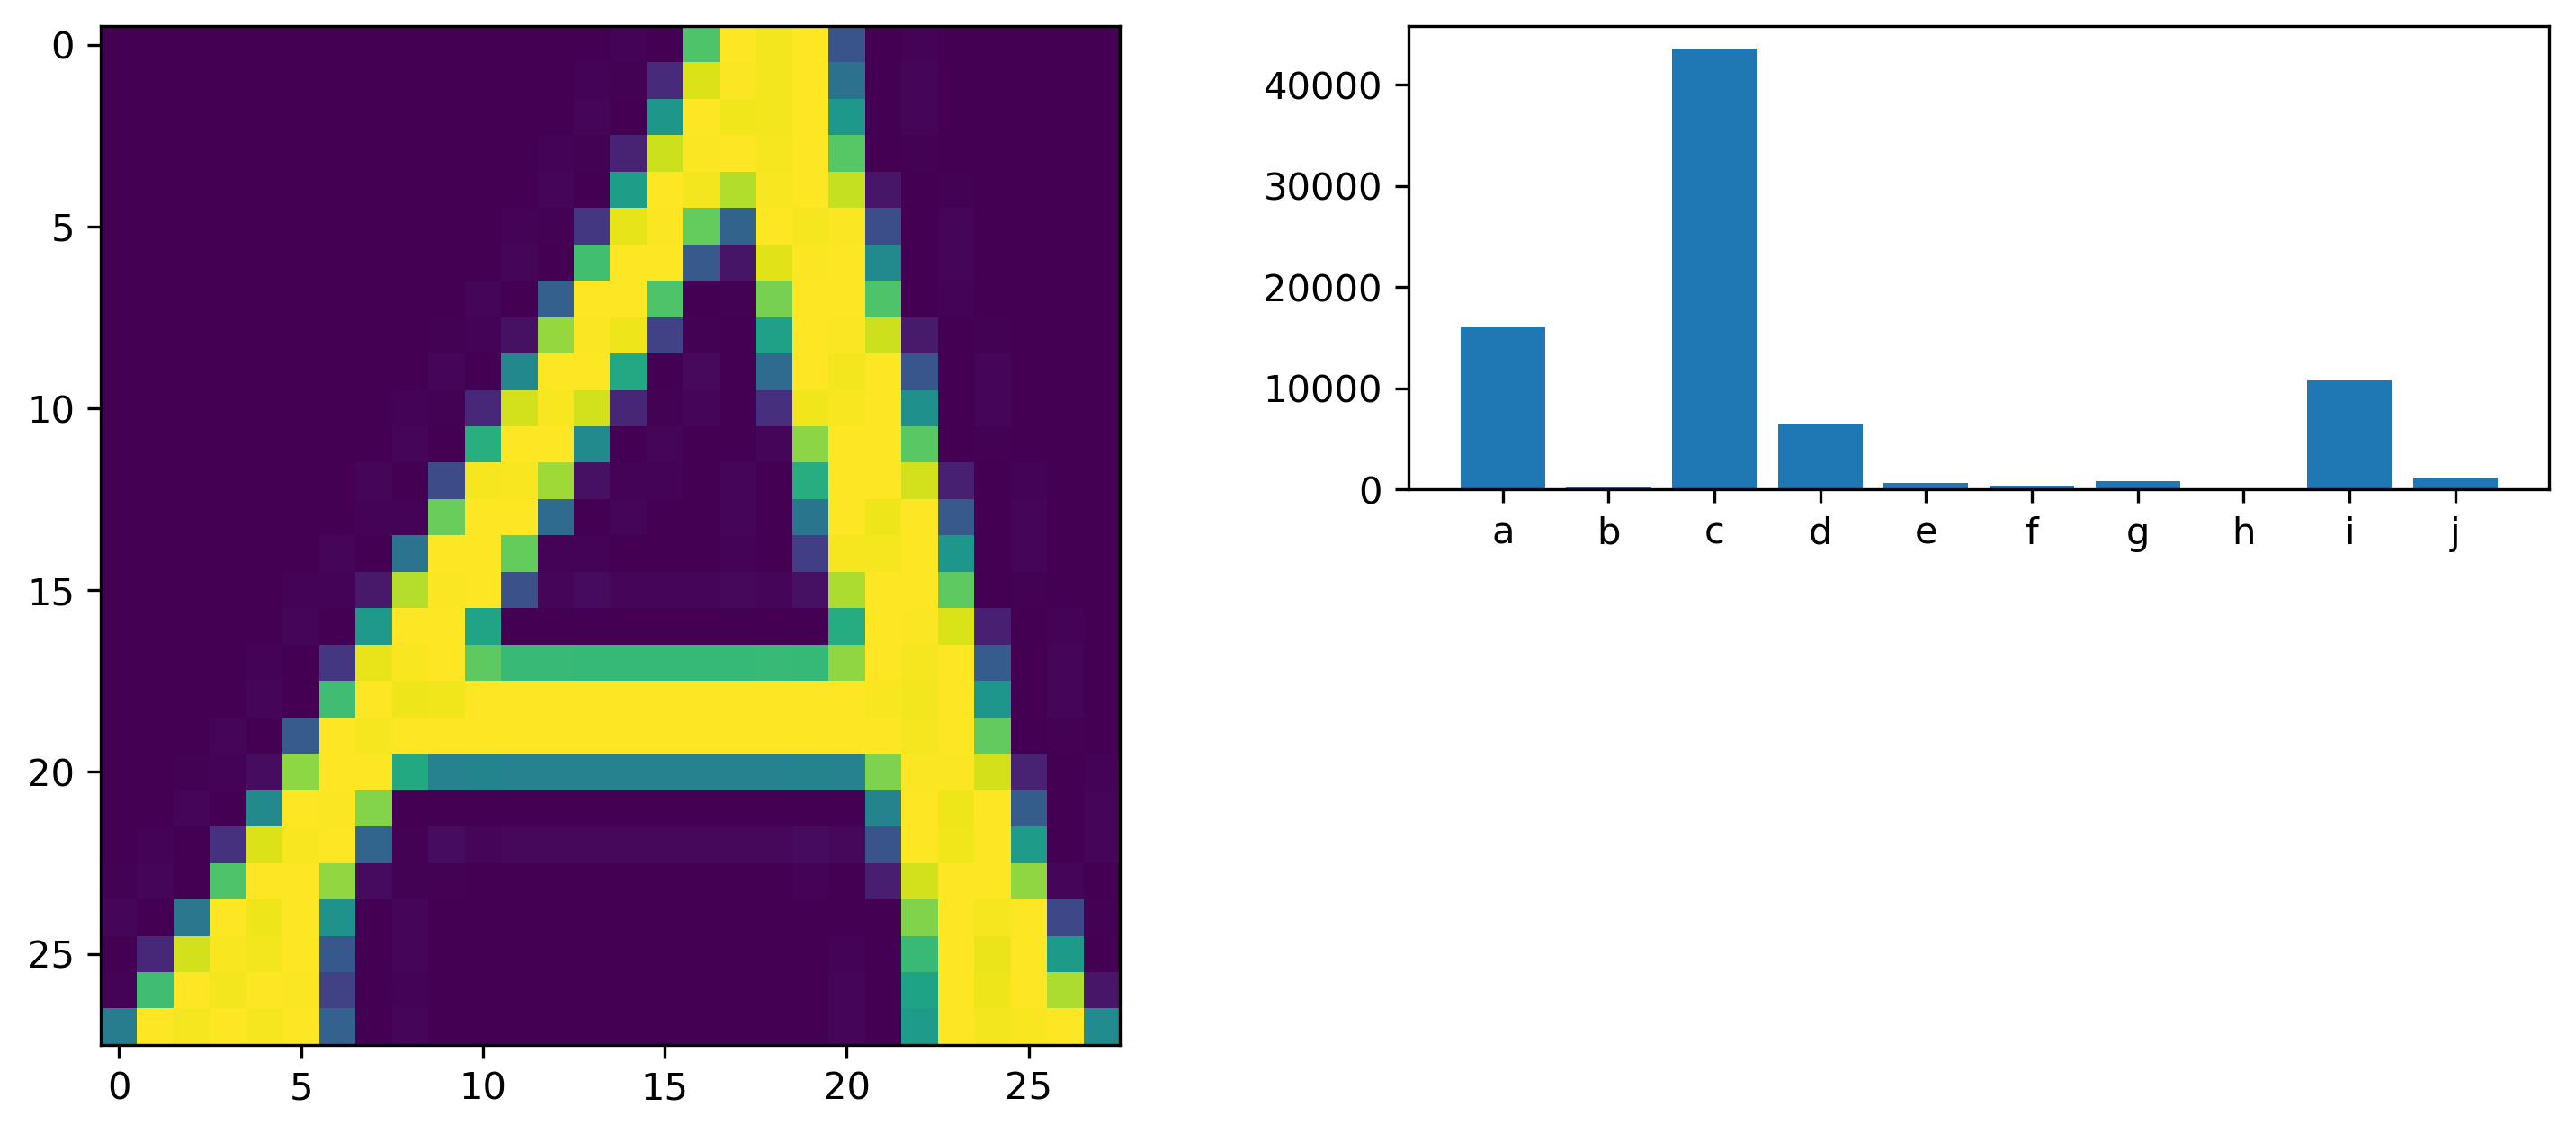

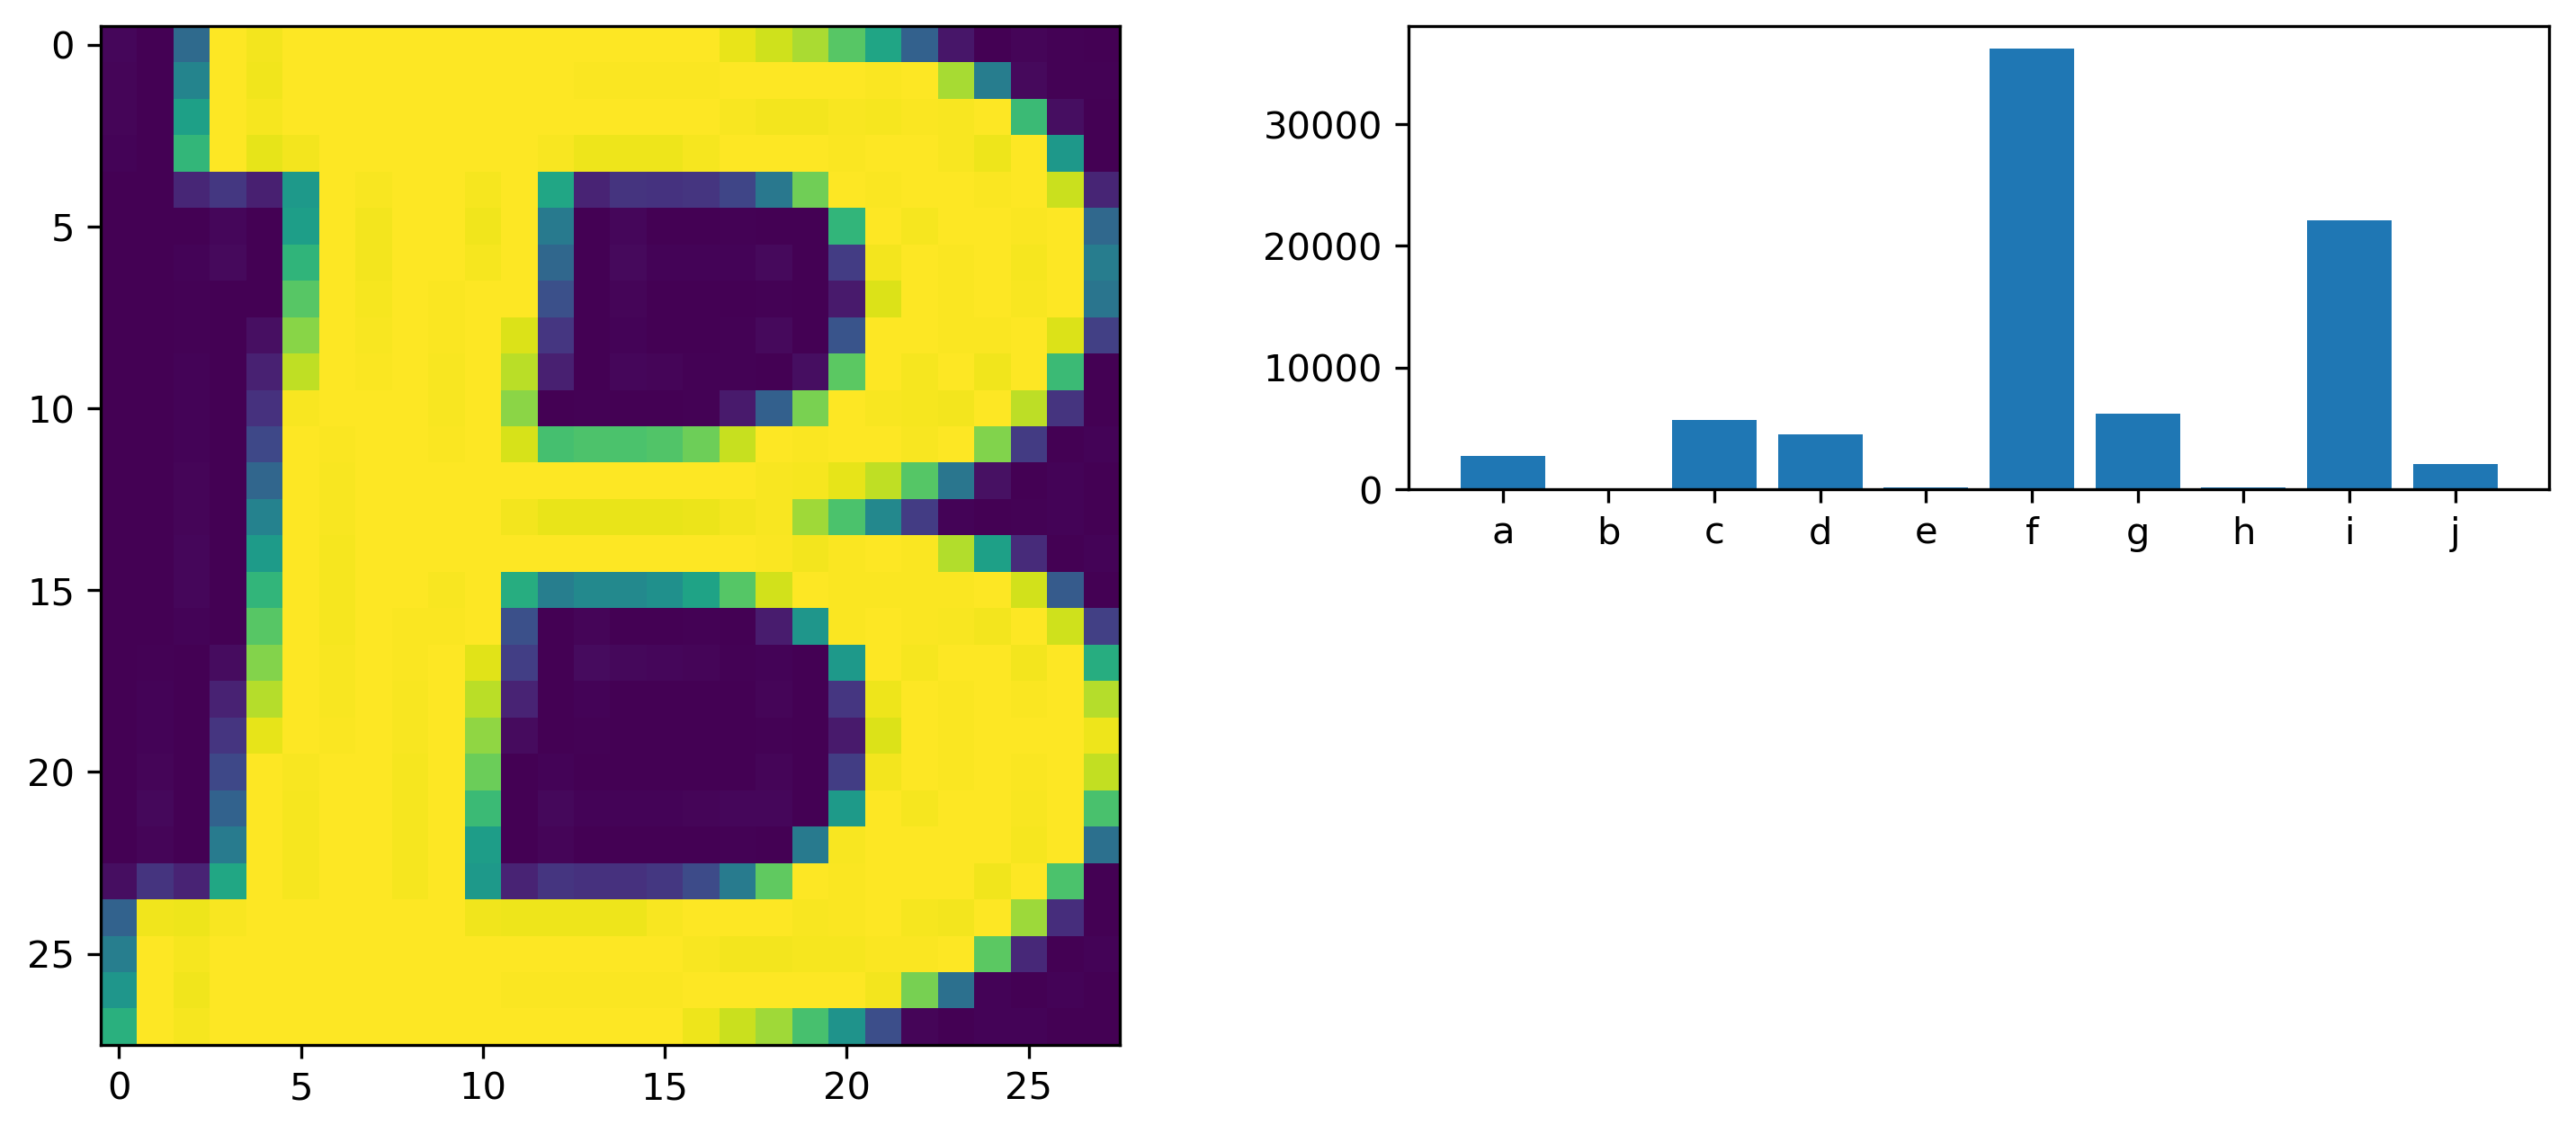

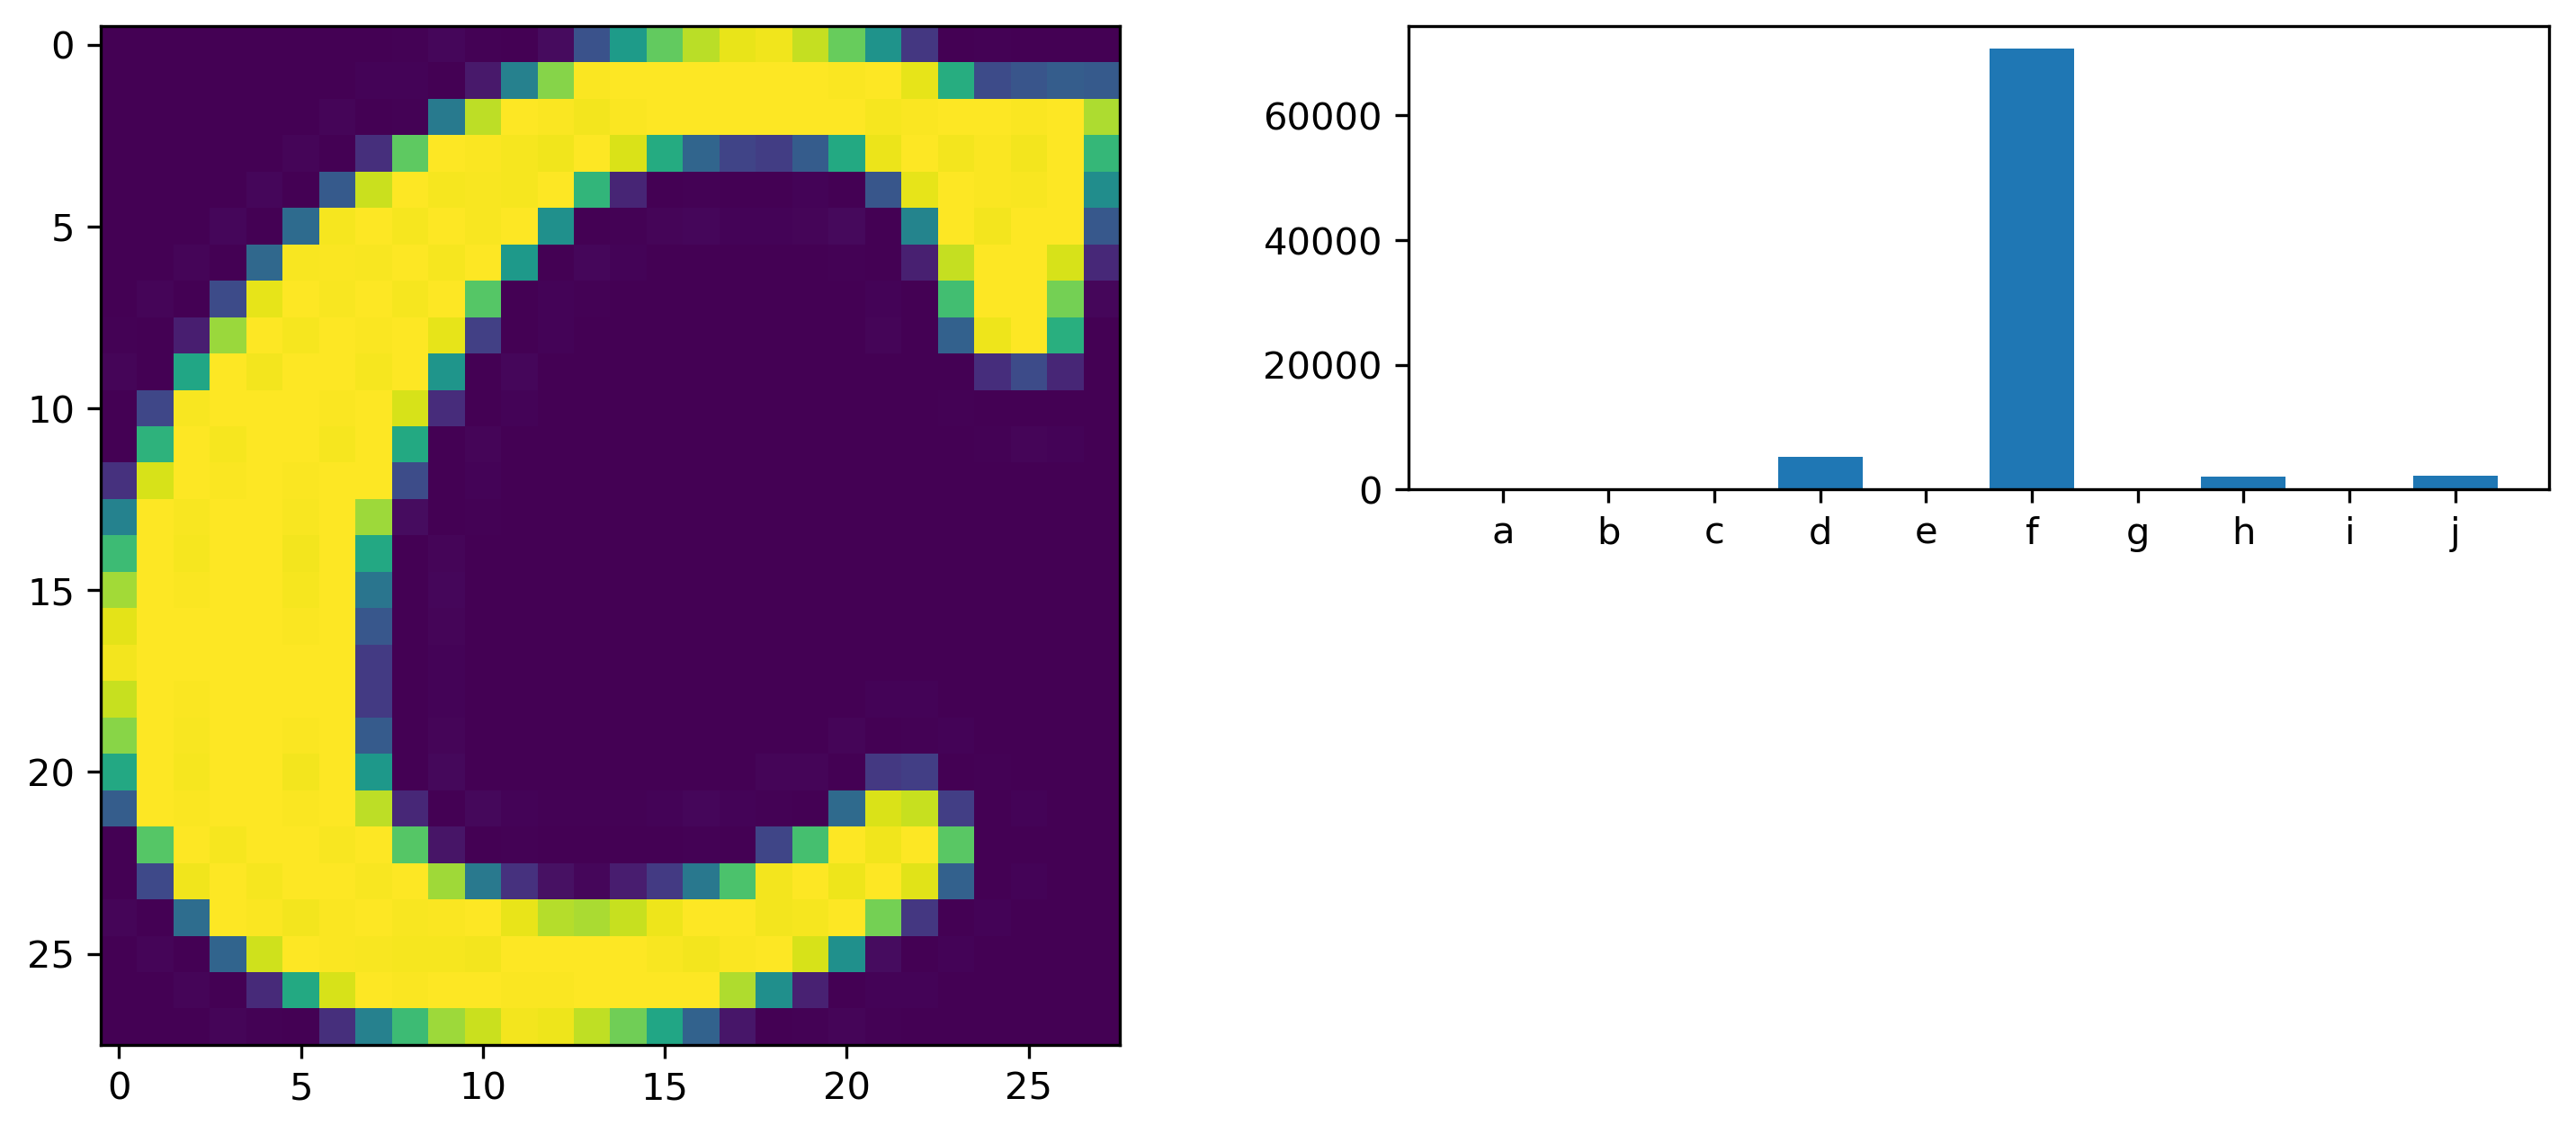

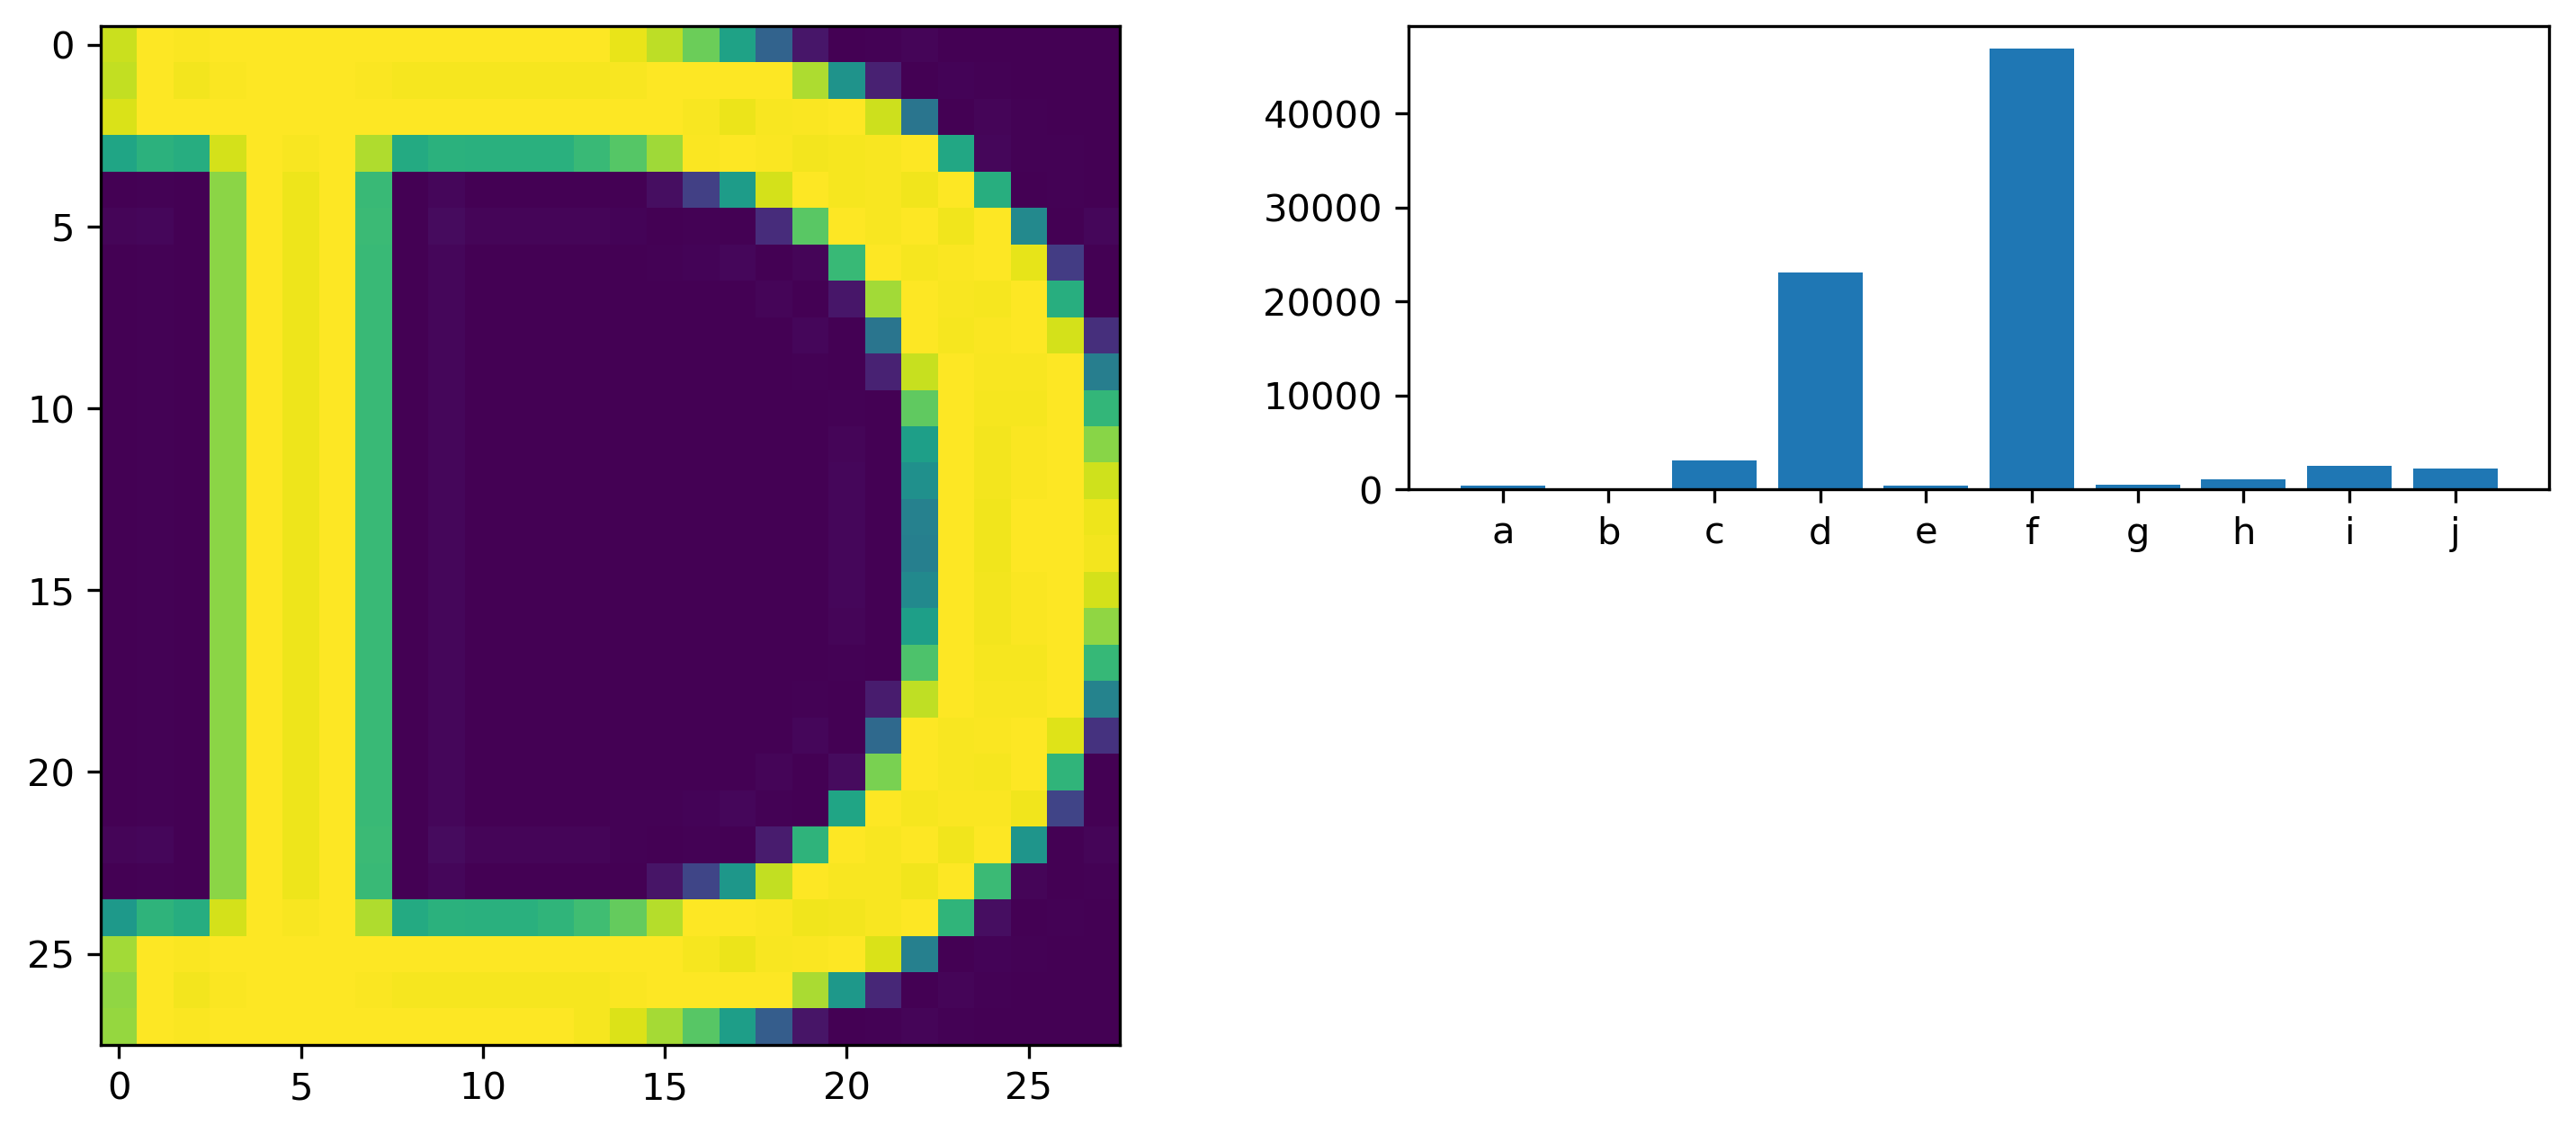

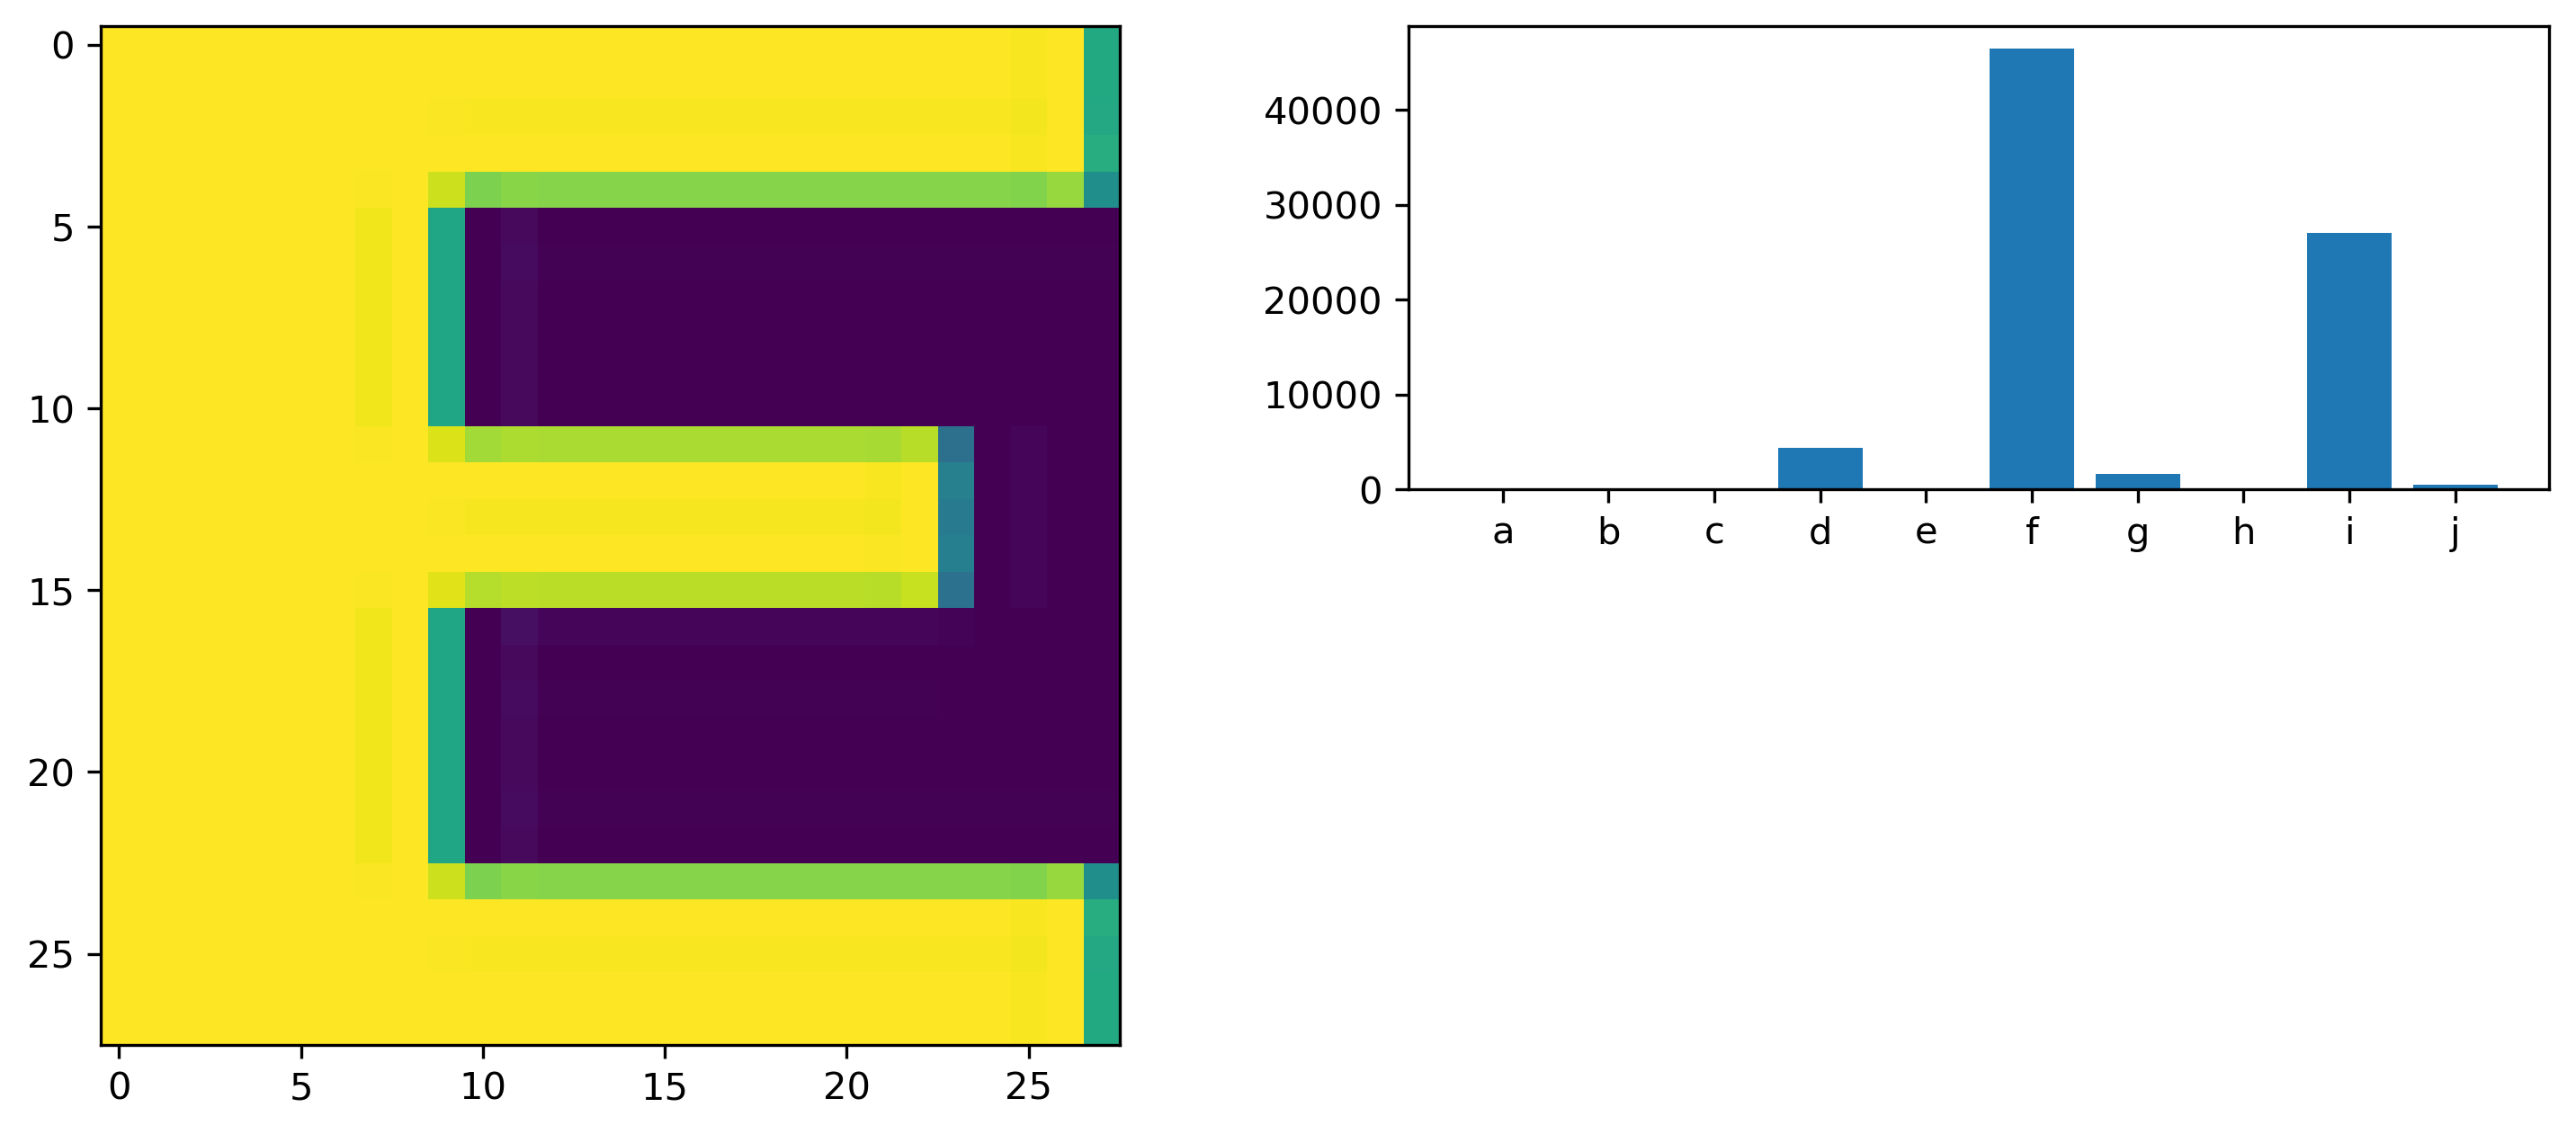

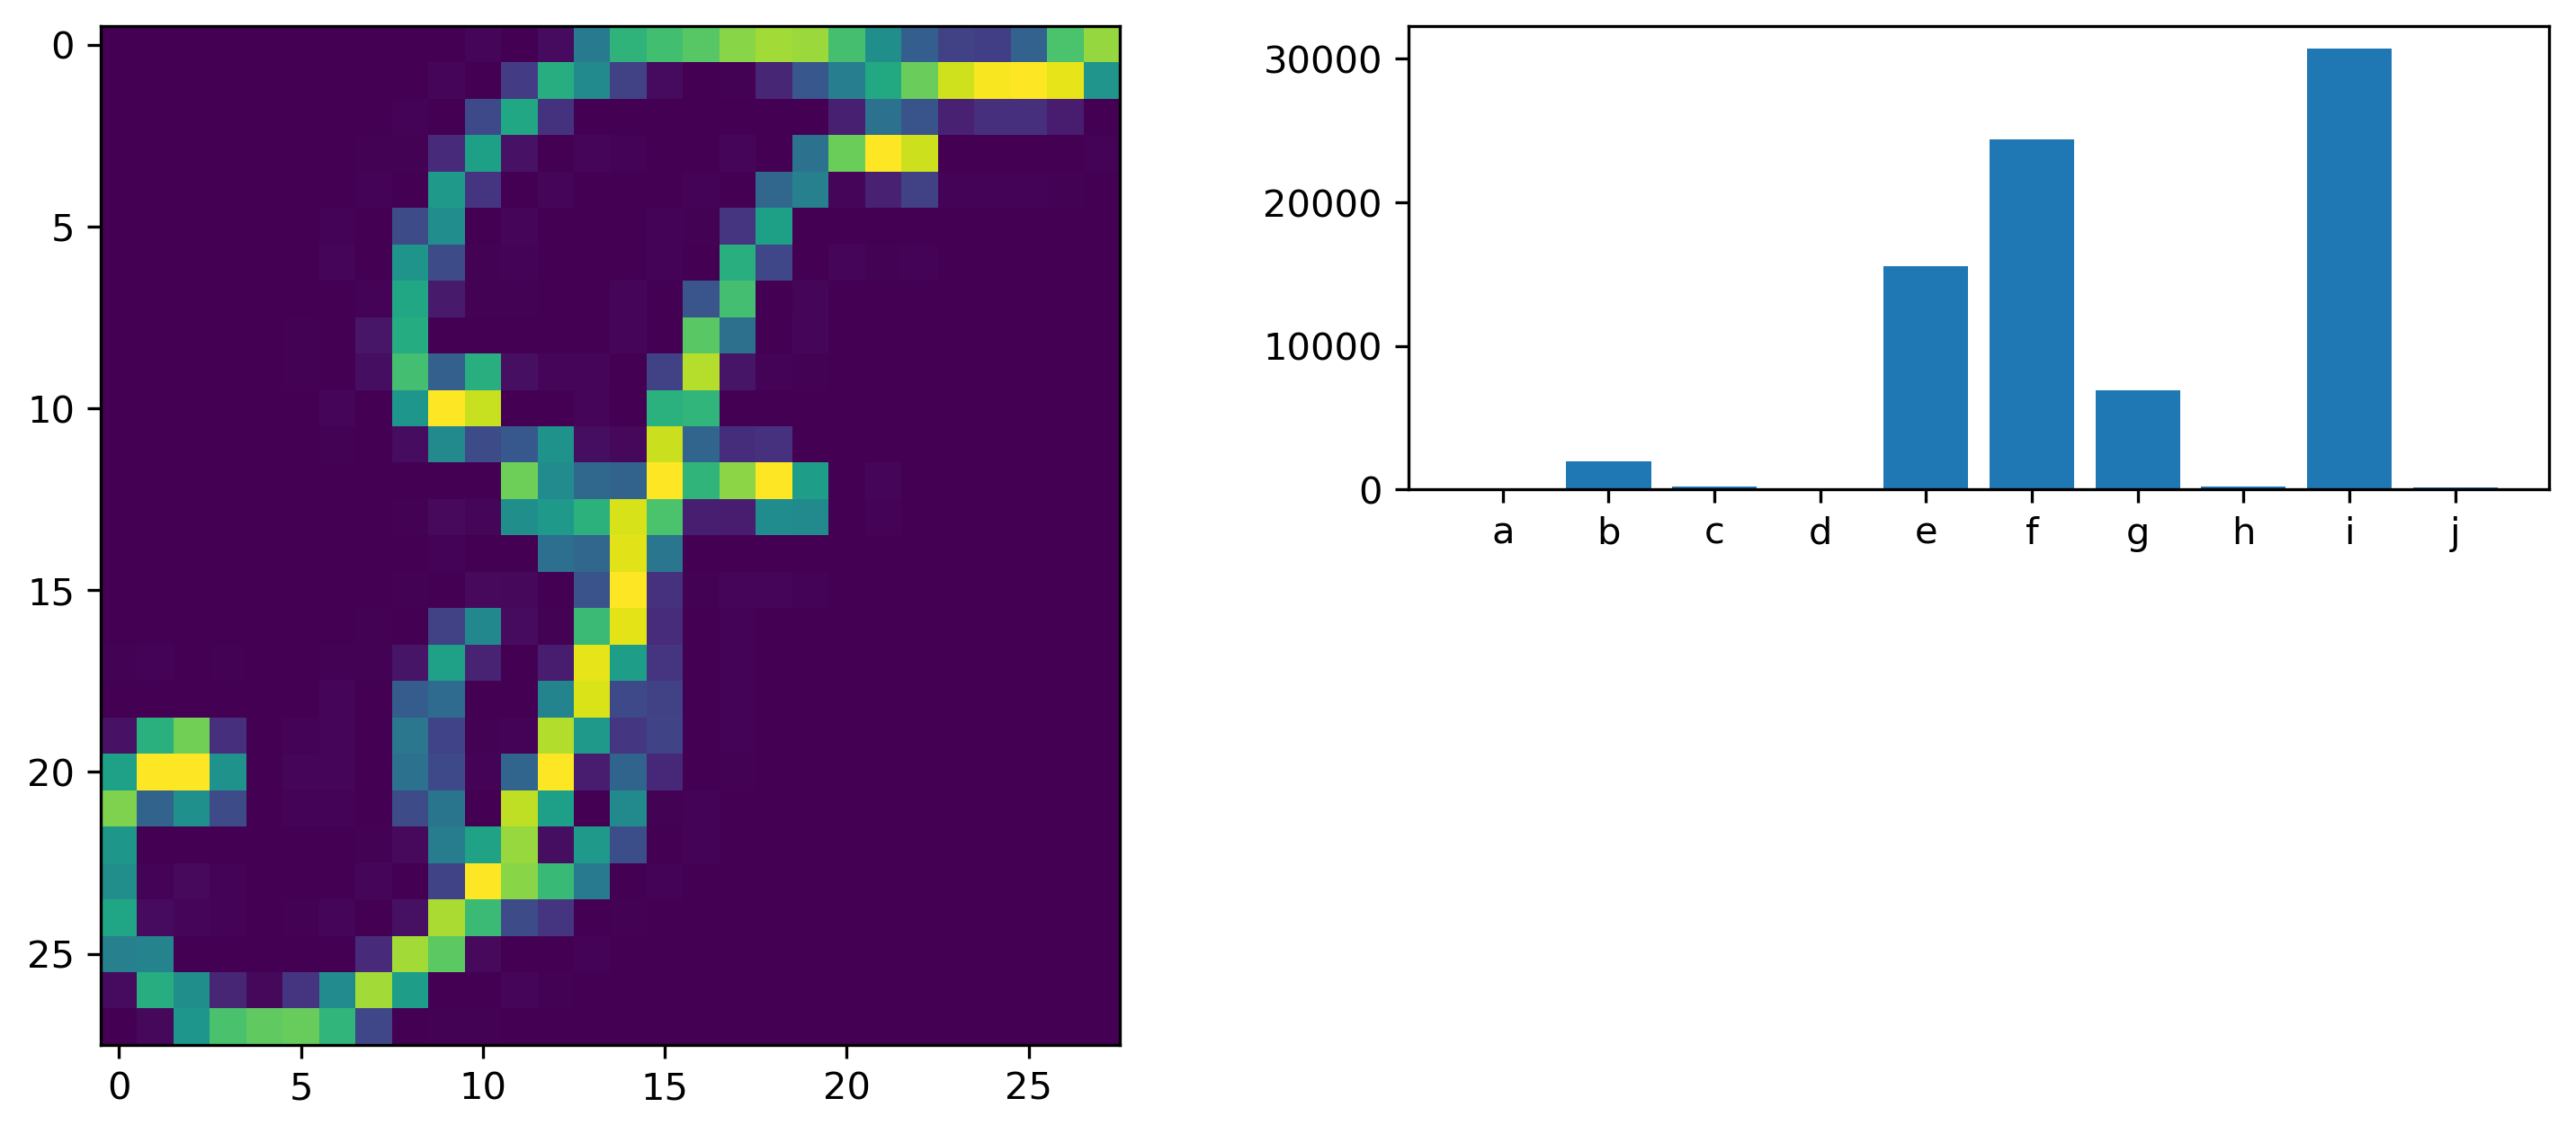

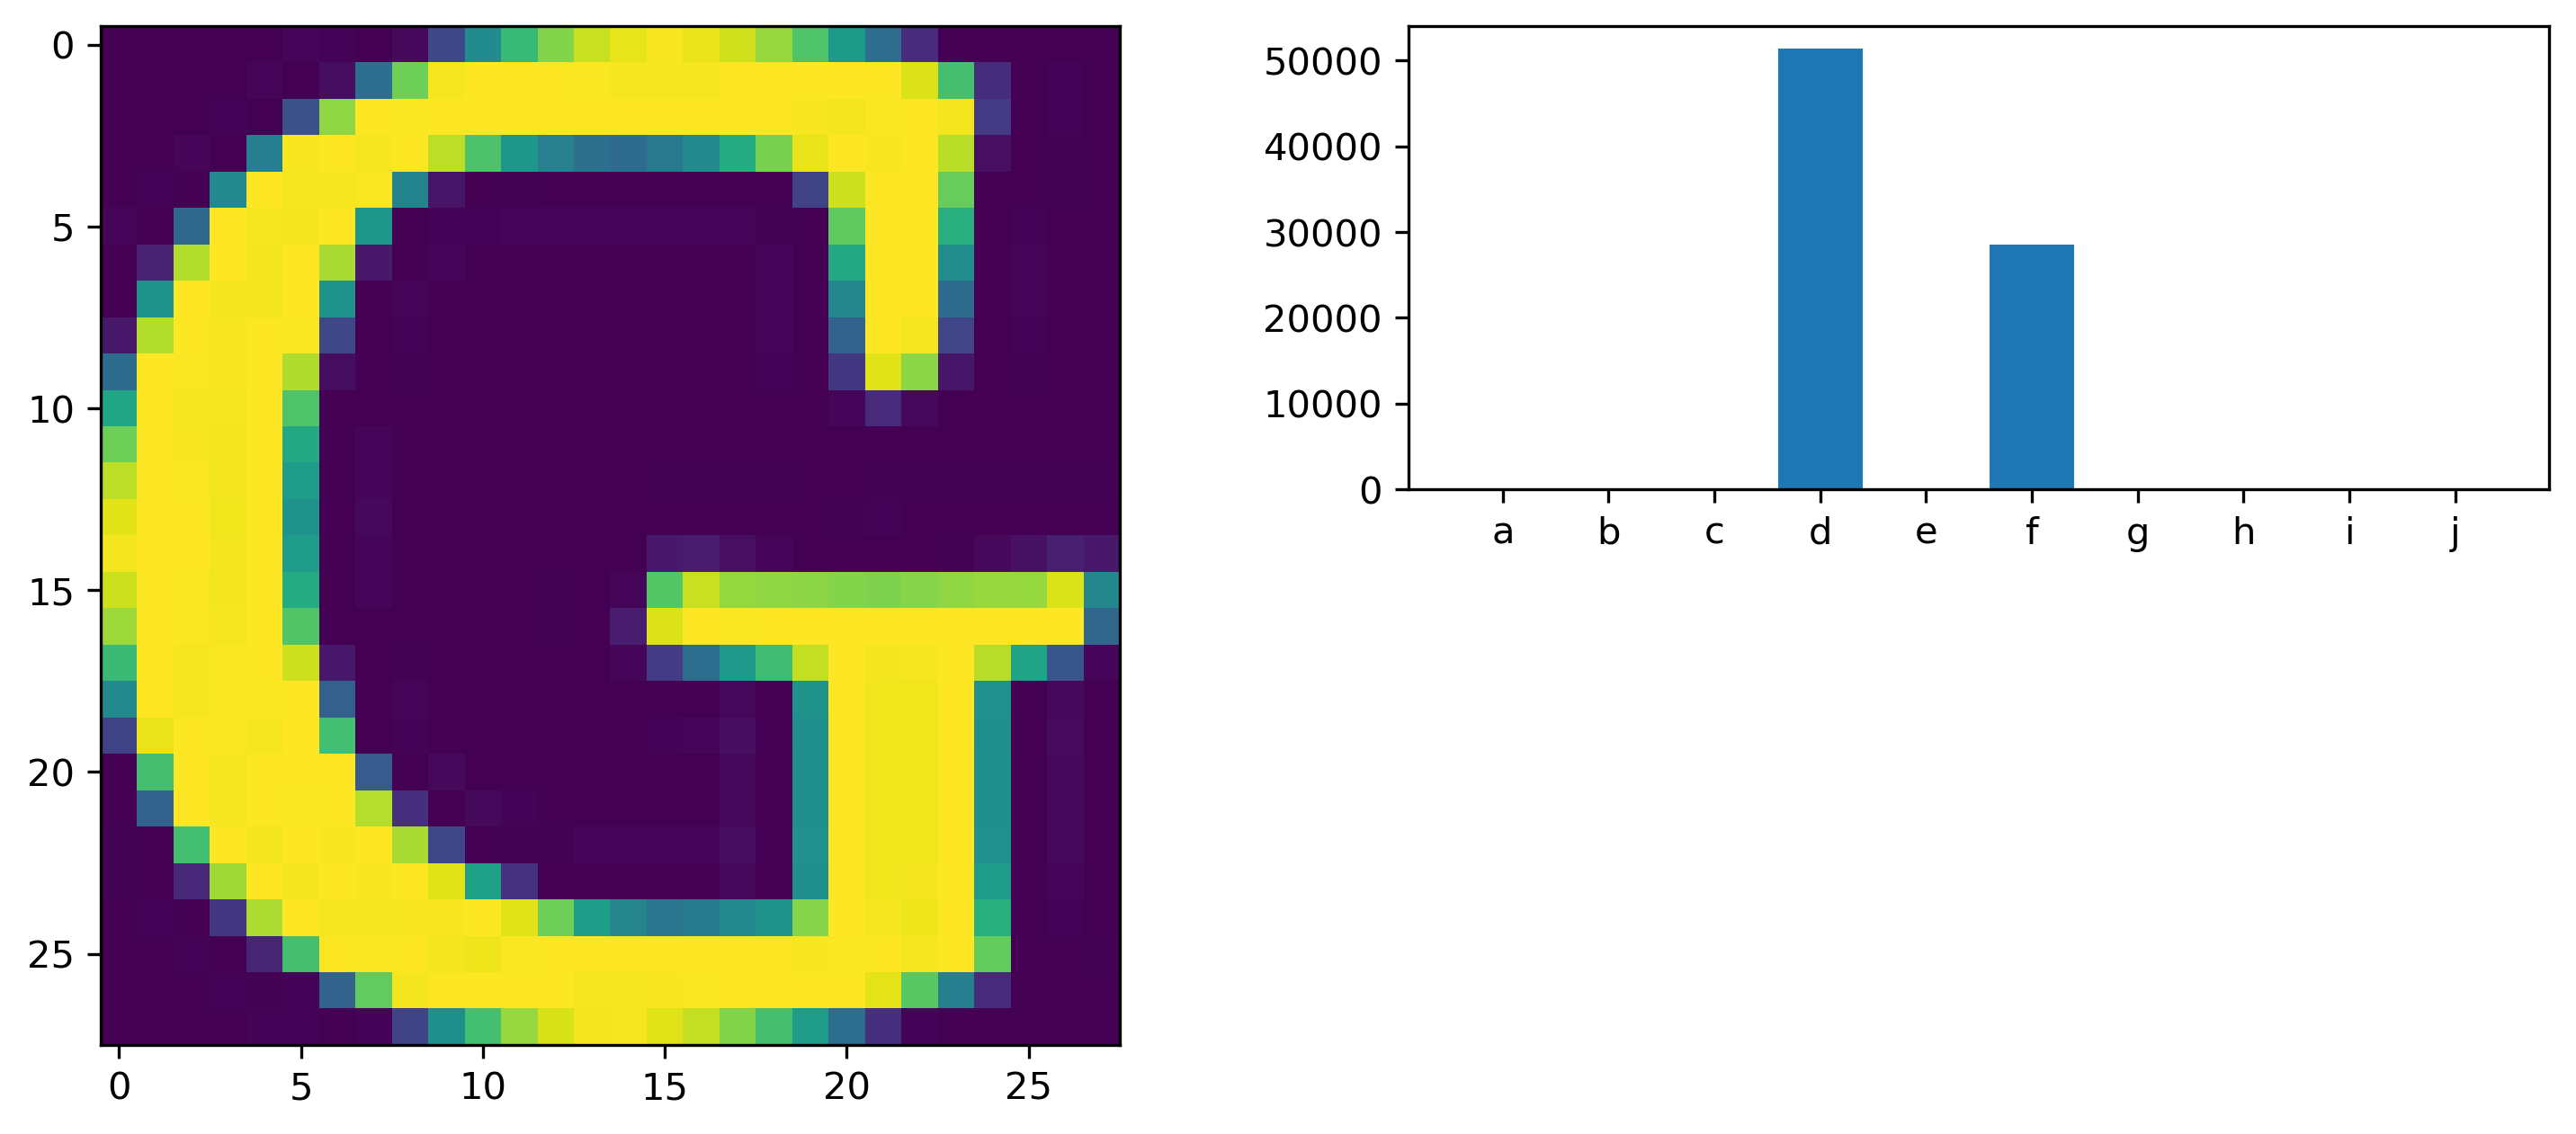

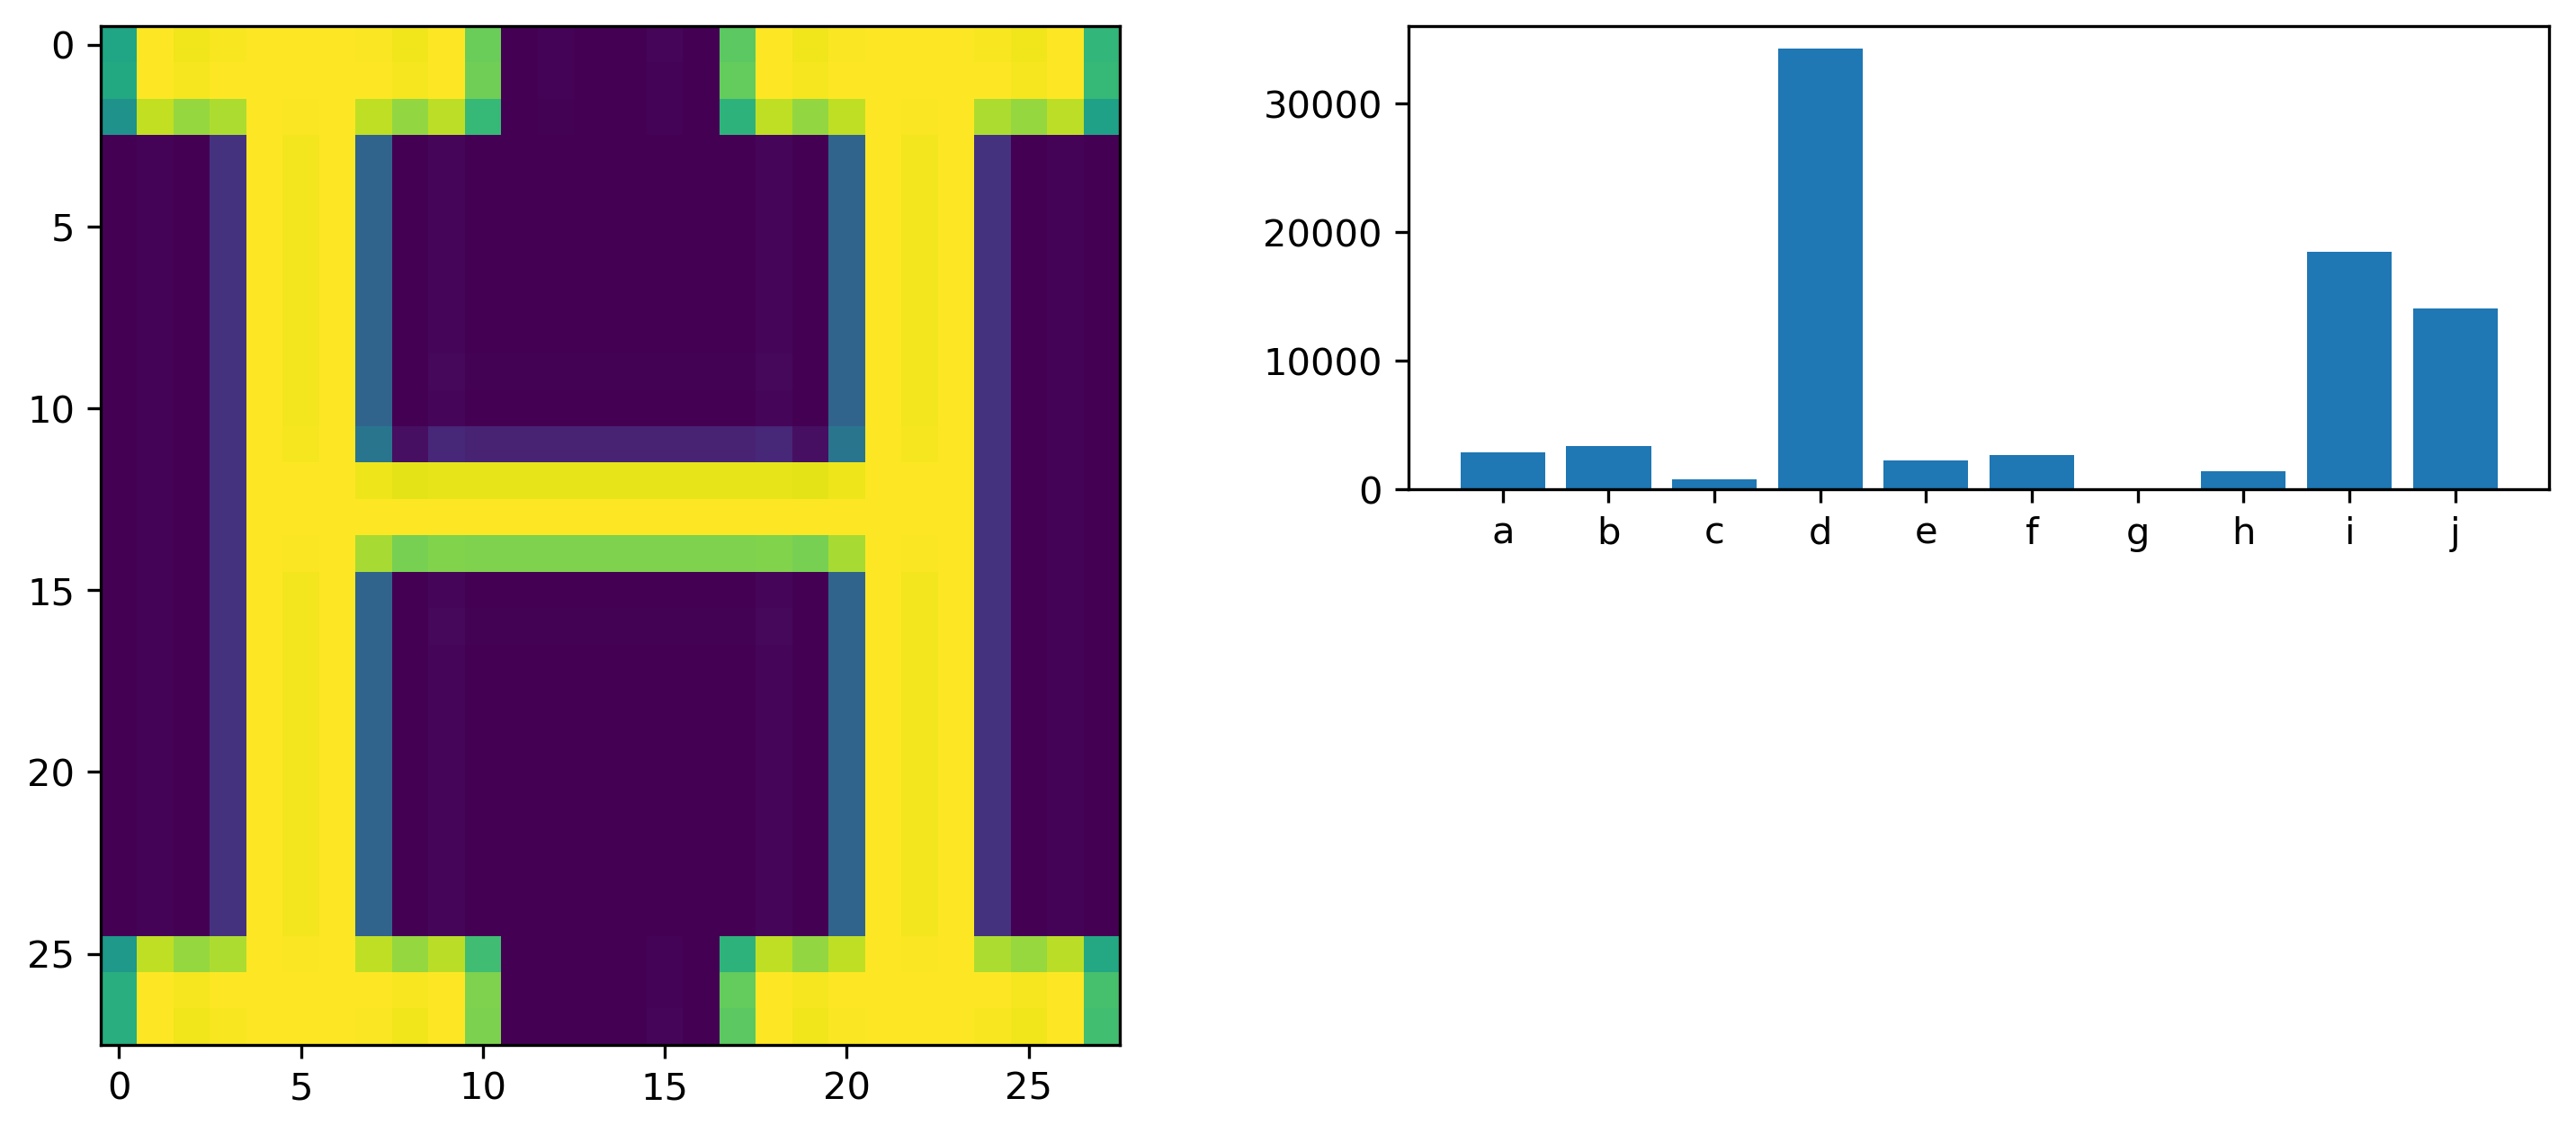

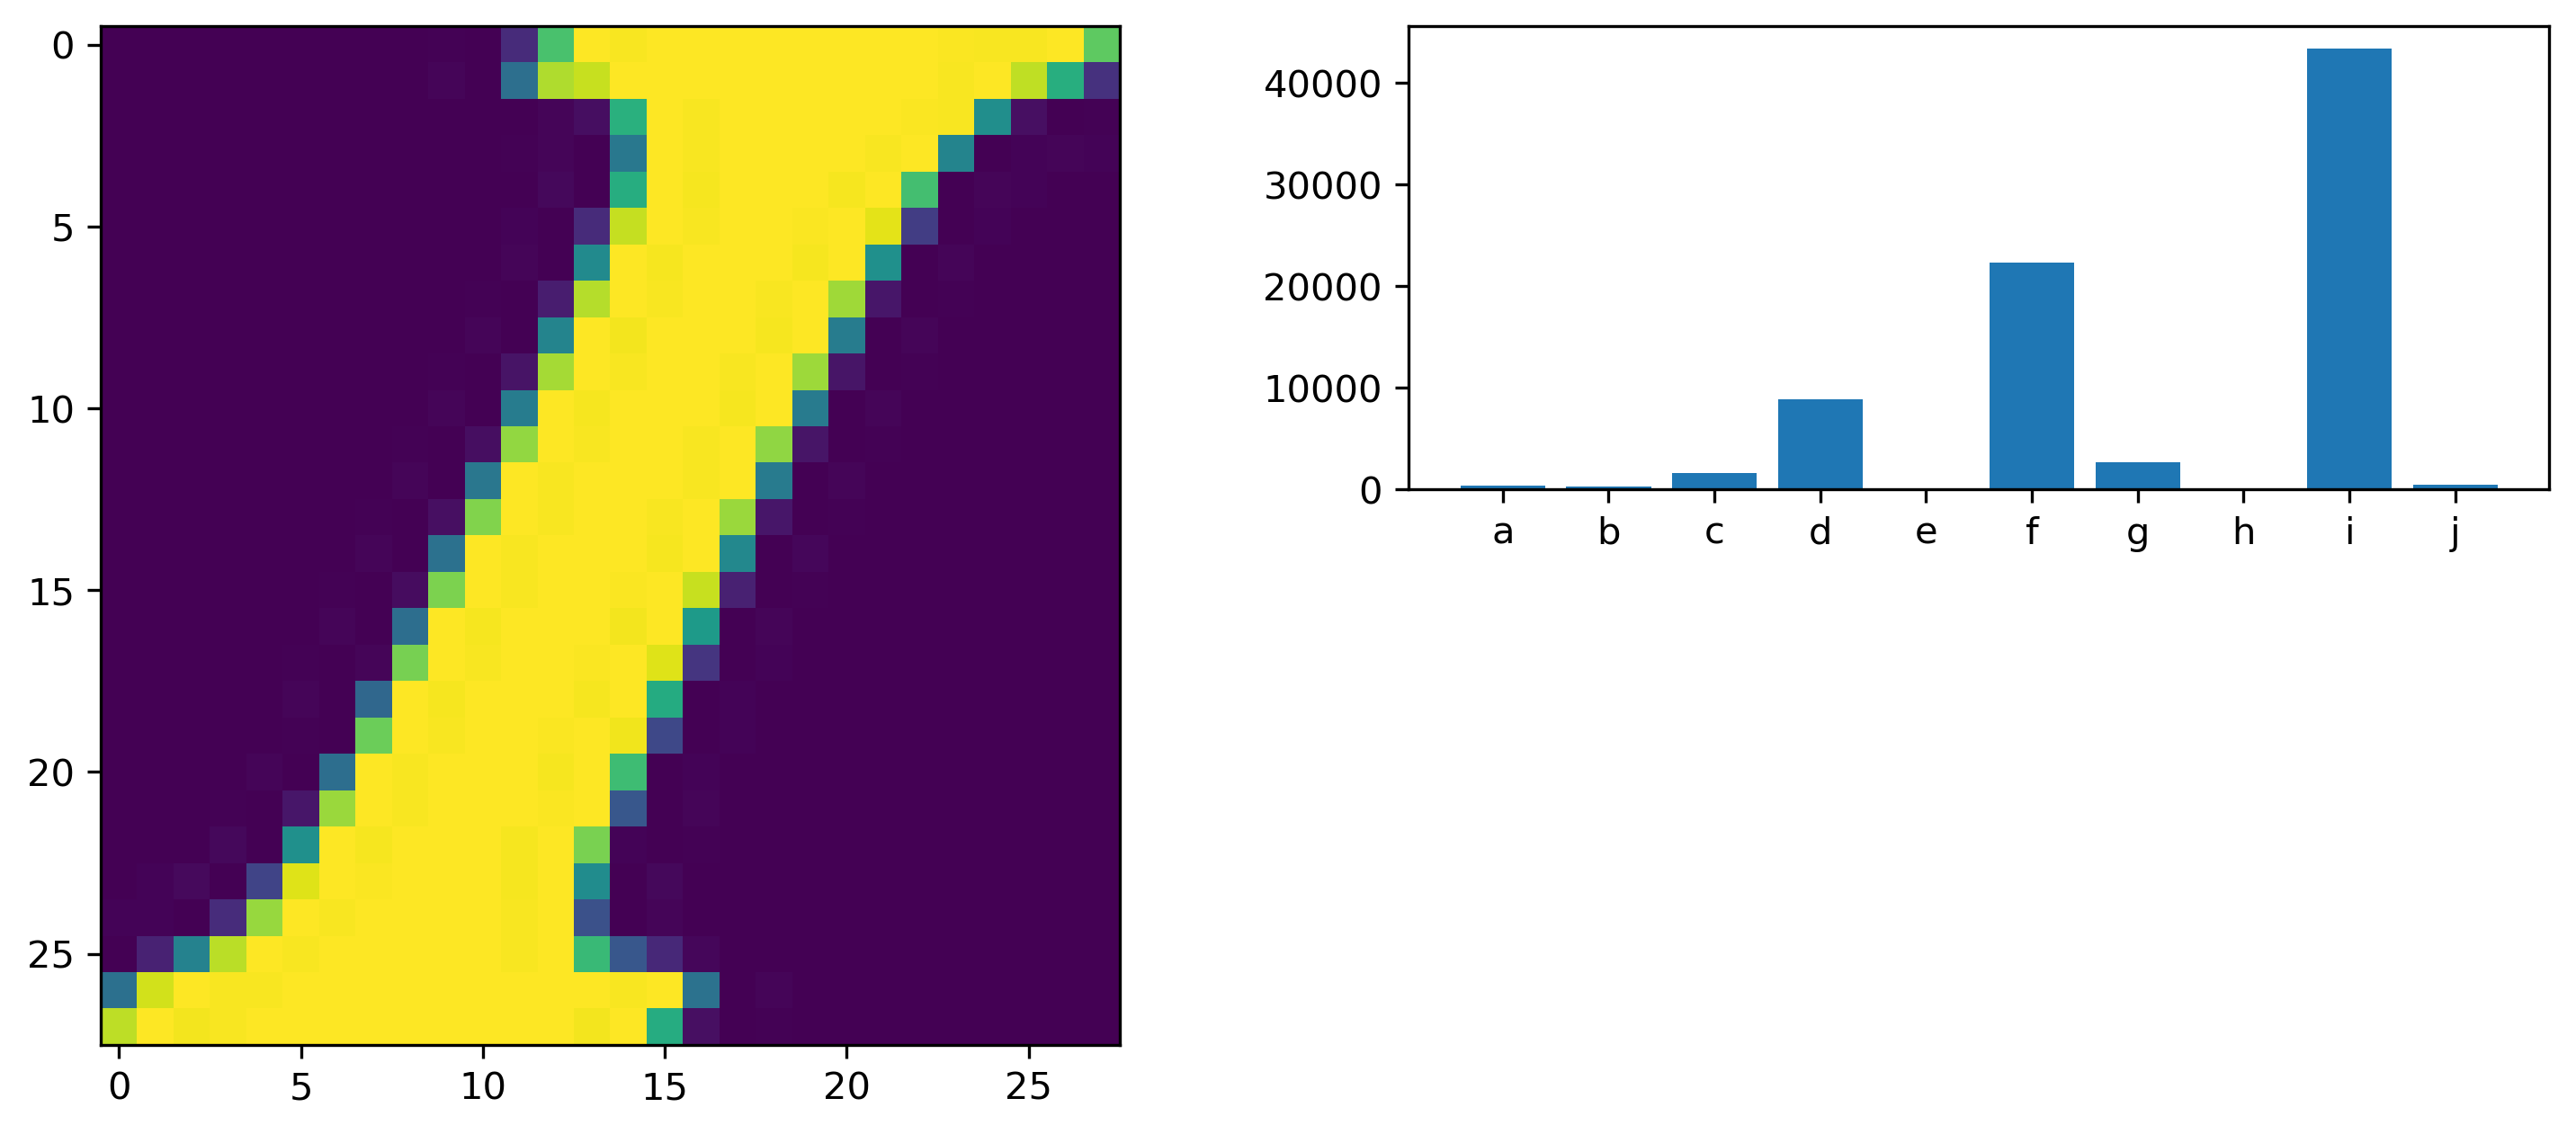

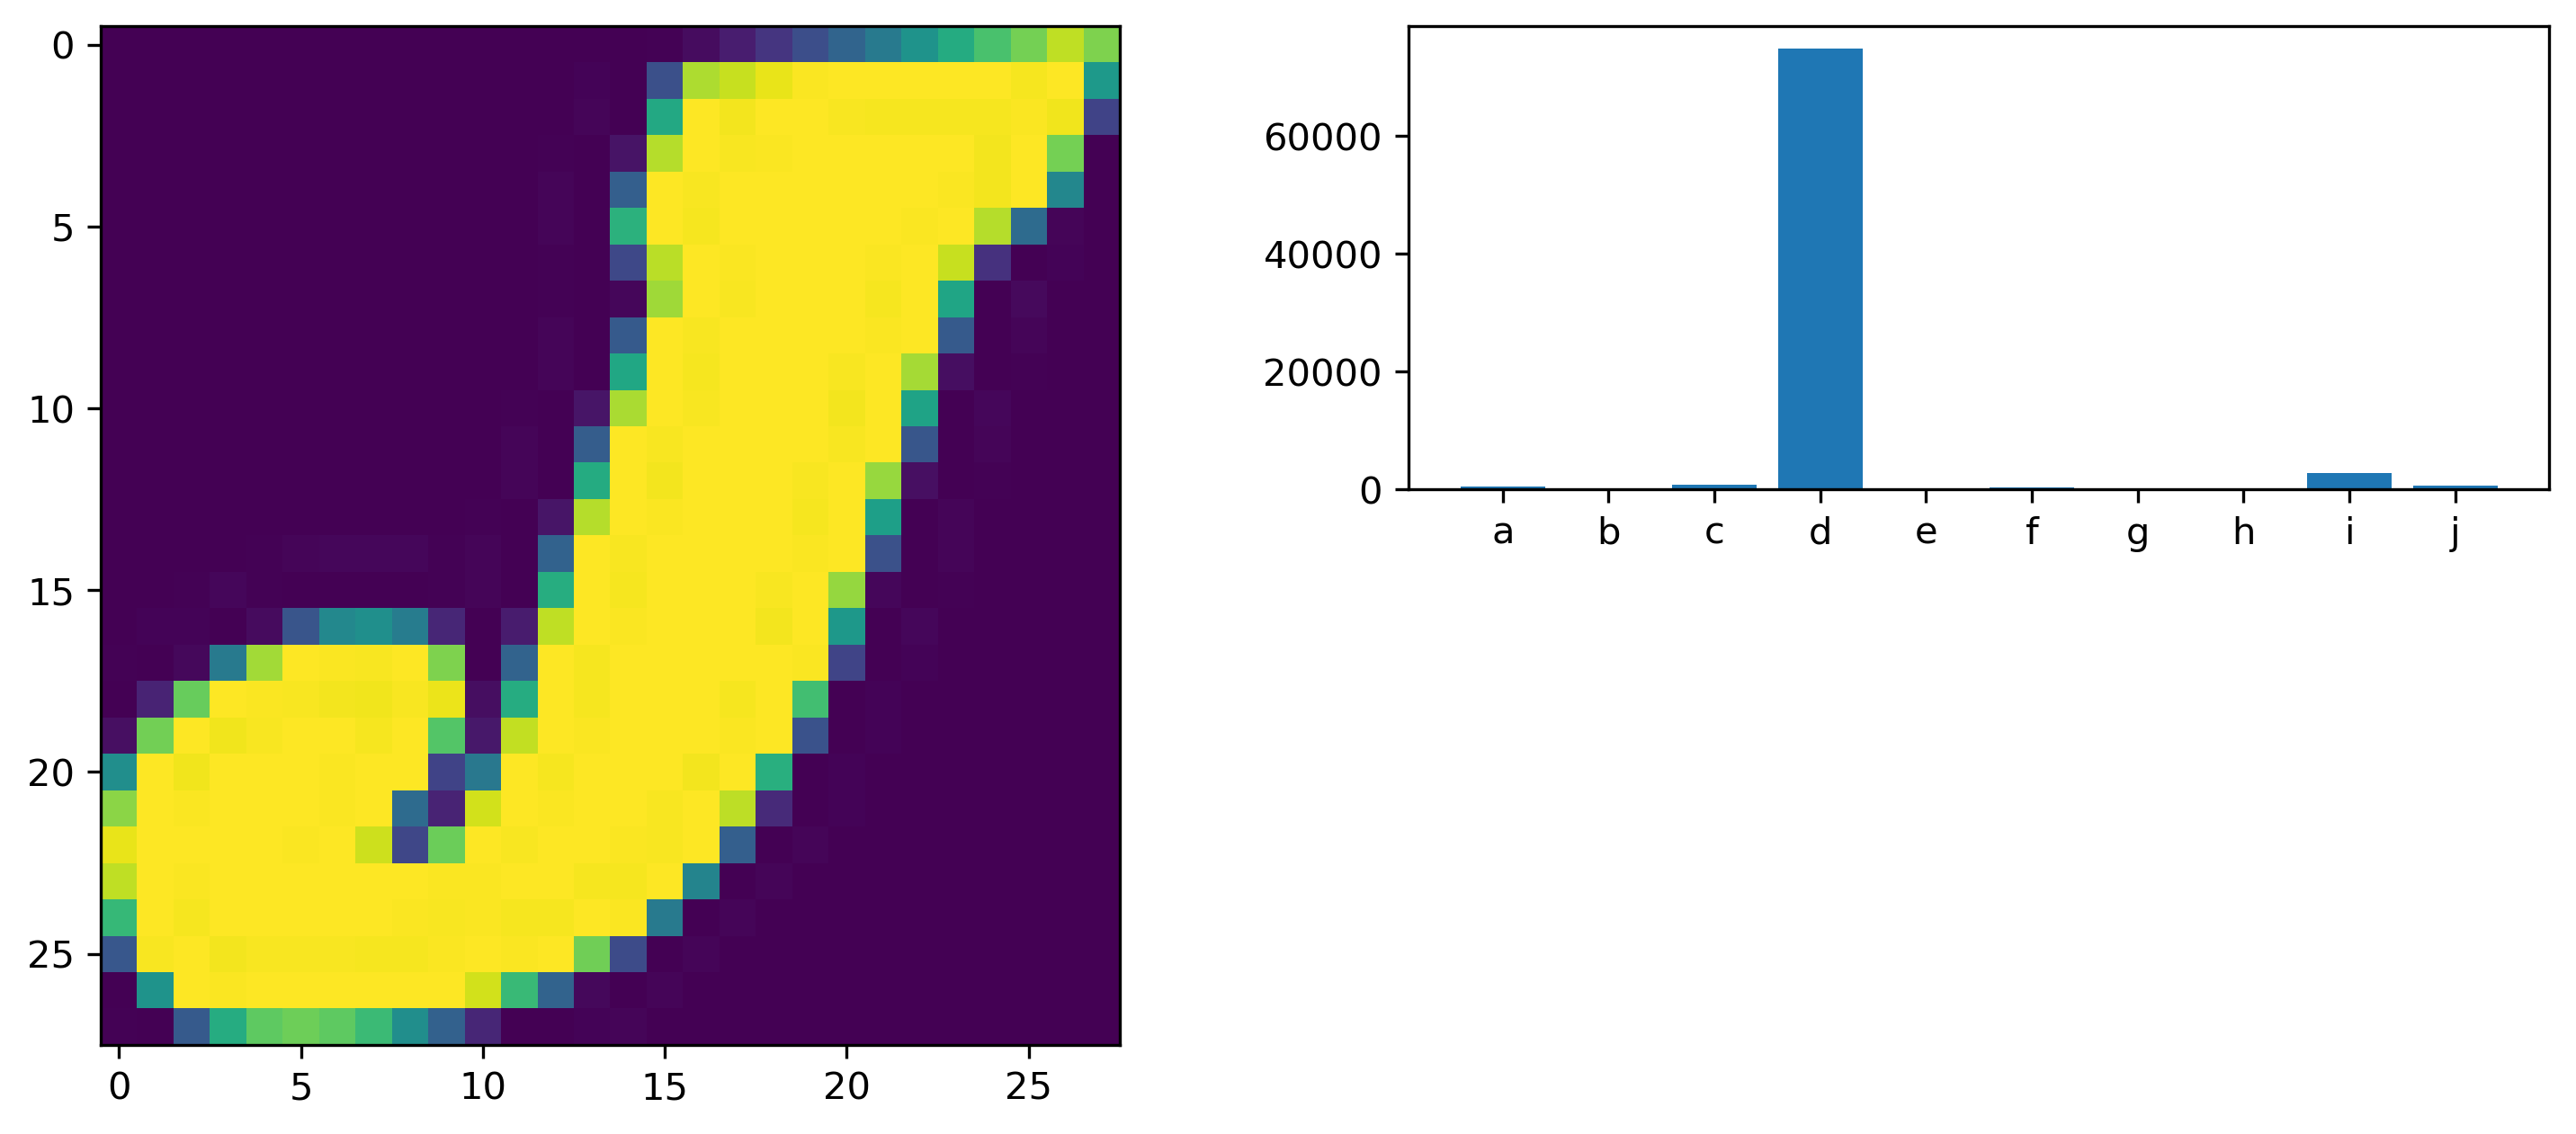

In [12]:
for iplot, letter_predictive in enumerate(full_letter_predictive):
    posterior_dist = letter_predictive.to(torch.int64).numpy()
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.imshow(x_letters[iplot].numpy())
    plt.subplot(2,2,2)
    plt.bar(letters, posterior_dist) 
    plt.show()